In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib
import matplotlib.pyplot as plt

In [3]:
import display
import dataloader
from dataloader import ThermalData
import clustering
import anomaly_detection

In [4]:
import module_extraction
#from module_extraction import Filters, Modules
from module_extraction_ortho import Filters, Modules

In [5]:
input_img_path = "./images/ortho/1466.tif"

In [6]:
input_dir_path = "./outputs/"+input_img_path.split("/")[-1][:-4]
print(input_dir_path)

./outputs/1466


画像データの取得

In [7]:
thermal_img_files = dataloader.get_img_files(dir_path=input_dir_path+"/modules",gray=False)
#thermal_img_files_gray = dataloader.get_img_files(dir_path=input_dir_path+"/modules",gray=True)

In [8]:
type(thermal_img_files), len(thermal_img_files)

(dict, 5216)

In [9]:
img_org = cv2.imread(input_img_path, 0)

モジュール情報の取得

In [10]:
import pickle
with open(input_dir_path+'/module_contours.pkl', 'rb') as pkl:
    module_contours = pickle.load(pkl)
#with open(input_dir_path+'/module_labels.pkl', 'rb') as pkl:
with open(input_dir_path+'/module_labels_split.pkl', 'rb') as pkl:
    module_labels = pickle.load(pkl)

温度分布の確認

In [11]:
data = ThermalData(thermal_img_files, scale_type="individual")

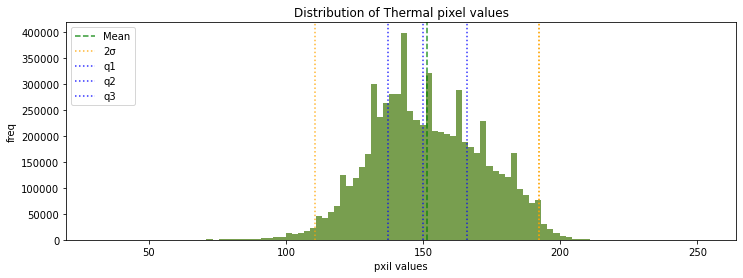

In [12]:
display.display_distributions(data.all_temperature, 
                              filepath = "hist_all_temperature.jpg")

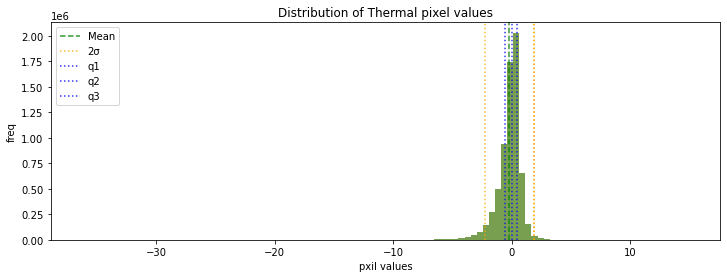

In [13]:
display.display_distributions(data.scaled_all_temperature,
                              filepath = "hist_scaled_all_temperature.jpg")

温度分布の確認（アレイごと）

In [14]:
from sklearn import preprocessing

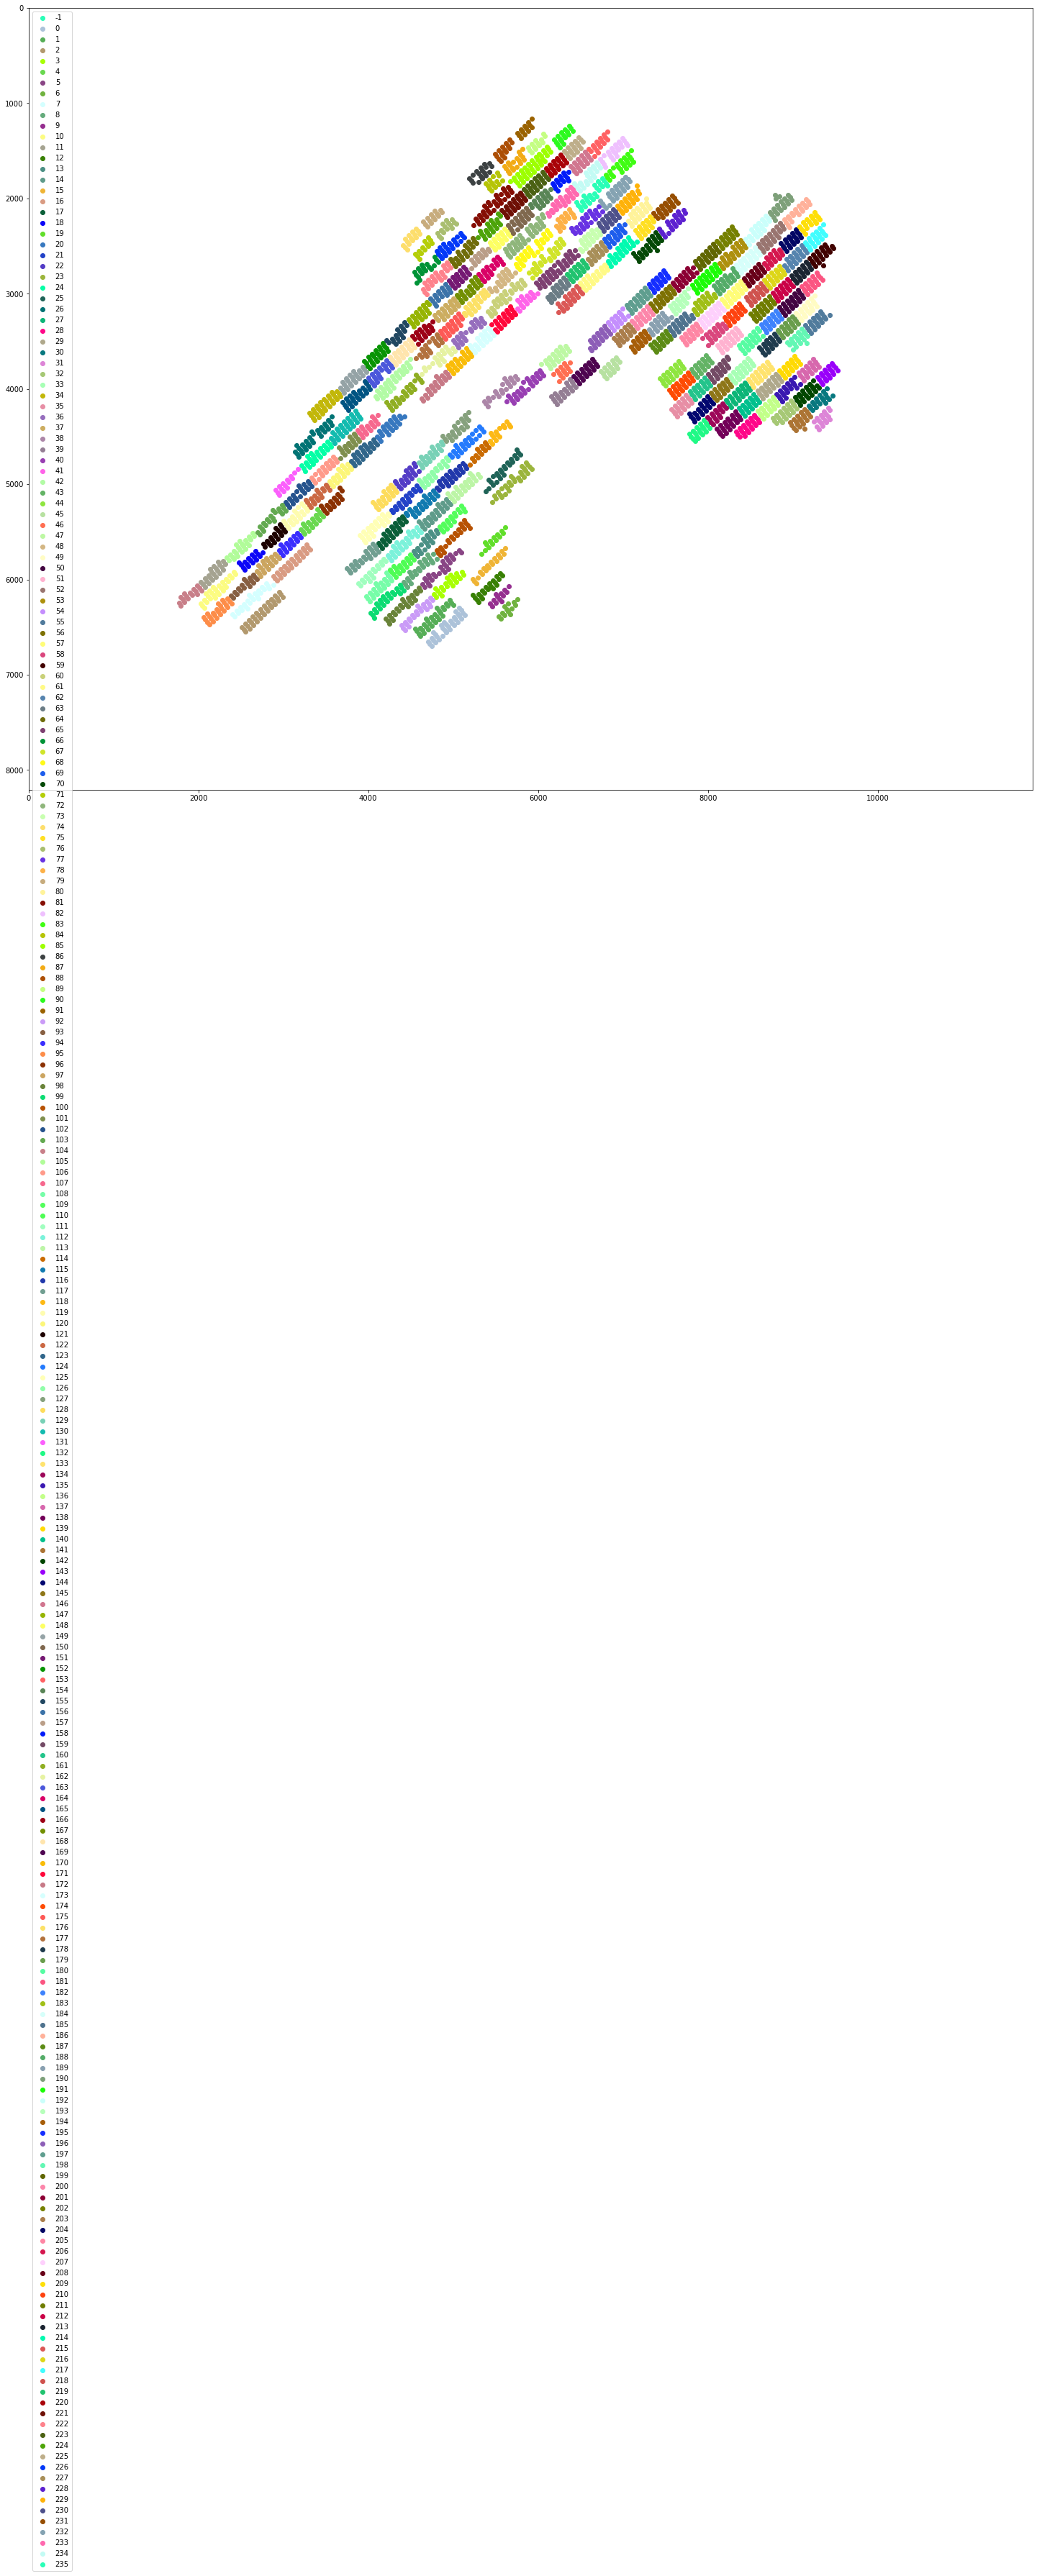

In [15]:
fig, ax = plt.subplots(facecolor="w", figsize=(25,20))
#cmap = plt.get_cmap("tab20")
colors = list(matplotlib.colors.XKCD_COLORS.items())[:max(module_labels)+1]
module_centers = np.array( [c.mean(axis=0) for c in module_contours] )
for i in range(-1,max(module_labels)+1):
    data = module_centers[module_labels == i]
    plt.scatter(data[:, 0], data[:, 1], color=colors[i][1], label=str(i))
#plt.scatter(module_centers[:, 0], module_centers[:, 1], color=cmap(module_labels+1), label=)
ax.legend(loc='upper left')
ax.set_xlim([0, img_org.shape[1]])
ax.set_ylim([img_org.shape[0], 0])
plt.show()

In [16]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest

In [17]:
# This will be implemented in ThermalData class
data_array = {}; array_scaler= {}; 
for c in range(0,max(module_labels)+1):
    indices = np.where(module_labels==c)
    np.where(module_labels==c)
    target_thermal_img_files = pd.Series(thermal_img_files).iloc[indices]
    data_array[c] = ThermalData(target_thermal_img_files, scale_type="individual")
    rscaler = preprocessing.RobustScaler()
    array_scaler[c] = rscaler.fit(data_array[c].all_temperature)

In [18]:
clustering_method="kmeans"
#clustering_method="xmeans" # not stable
#clustering_method="dbscan"

In [19]:
# clusters temperature 
array_clusters_temperature = {}
for c in range(0,max(module_labels)+1):
    tmp = []
    print("array:", c)
    print("--> generate clusters temperature")
    # -- clustering --
    for k, v in data_array[c].scaled_temperature_with_index.items():
        clusters = clustering.TemperatureClusters(v, method=clustering_method)  
        sliced_data = clusters.get_clusters_data(data_array[c].temperature[k])   
        original_clusters_temperature = np.stack([np.uint8(t.mean(axis=0)) for t in sliced_data])
        tmp.append(original_clusters_temperature)
    array_clusters_temperature[c] = np.vstack(tmp)

array: 0
--> generate clusters temperature
array: 1
--> generate clusters temperature
array: 2
--> generate clusters temperature
array: 3
--> generate clusters temperature
array: 4
--> generate clusters temperature
array: 5
--> generate clusters temperature
array: 6
--> generate clusters temperature
array: 7
--> generate clusters temperature
array: 8
--> generate clusters temperature
array: 9
--> generate clusters temperature
array: 10
--> generate clusters temperature
array: 11
--> generate clusters temperature
array: 12
--> generate clusters temperature
array: 13
--> generate clusters temperature
array: 14
--> generate clusters temperature
array: 15
--> generate clusters temperature
array: 16
--> generate clusters temperature
array: 17
--> generate clusters temperature
array: 18
--> generate clusters temperature
array: 19
--> generate clusters temperature
array: 20
--> generate clusters temperature
array: 21
--> generate clusters temperature
array: 22
--> generate clusters temperatur

array: 185
--> generate clusters temperature
array: 186
--> generate clusters temperature
array: 187
--> generate clusters temperature
array: 188
--> generate clusters temperature
array: 189
--> generate clusters temperature
array: 190
--> generate clusters temperature
array: 191
--> generate clusters temperature
array: 192
--> generate clusters temperature
array: 193
--> generate clusters temperature
array: 194
--> generate clusters temperature
array: 195
--> generate clusters temperature
array: 196
--> generate clusters temperature
array: 197
--> generate clusters temperature
array: 198
--> generate clusters temperature
array: 199
--> generate clusters temperature
array: 200
--> generate clusters temperature
array: 201
--> generate clusters temperature
array: 202
--> generate clusters temperature
array: 203
--> generate clusters temperature
array: 204
--> generate clusters temperature
array: 205
--> generate clusters temperature
array: 206
--> generate clusters temperature
array: 207

In [20]:
# clf models
array_clf= {}
for c in range(0,max(module_labels)+1):
    print("array:", c)
    print("--> generate lof model")
    n_modules = len(data_array[c].temperature)
    #lof = LocalOutlierFactor(n_neighbors=n_modules, contamination="auto", novelty=True)
    lof = LocalOutlierFactor(n_neighbors=n_modules, contamination=0.01, novelty=True)    
    #lof = LocalOutlierFactor(n_neighbors=50, contamination=0.1, novelty=True)
    #isof = IsolationForest(random_state=0, contamination=0.02)   
    array_clf[c] = lof.fit(array_clusters_temperature[c])    

array: 0
--> generate lof model
array: 1
--> generate lof model
array: 2
--> generate lof model
array: 3
--> generate lof model
array: 4
--> generate lof model
array: 5
--> generate lof model
array: 6
--> generate lof model
array: 7
--> generate lof model
array: 8
--> generate lof model
array: 9
--> generate lof model
array: 10
--> generate lof model
array: 11
--> generate lof model
array: 12
--> generate lof model
array: 13
--> generate lof model
array: 14
--> generate lof model
array: 15
--> generate lof model
array: 16
--> generate lof model
array: 17
--> generate lof model
array: 18
--> generate lof model
array: 19
--> generate lof model
array: 20
--> generate lof model
array: 21
--> generate lof model
array: 22
--> generate lof model
array: 23
--> generate lof model
array: 24
--> generate lof model
array: 25
--> generate lof model
array: 26
--> generate lof model
array: 27
--> generate lof model
array: 28
--> generate lof model
array: 29
--> generate lof model
array: 30
--> genera

array: 0


No handles with labels found to put in legend.


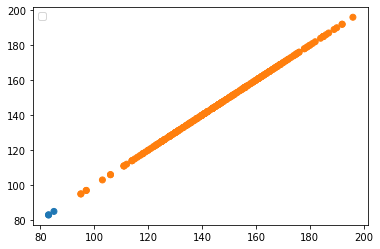

array: 1


No handles with labels found to put in legend.


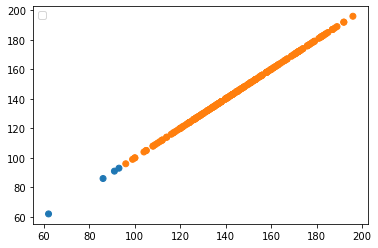

No handles with labels found to put in legend.


array: 2


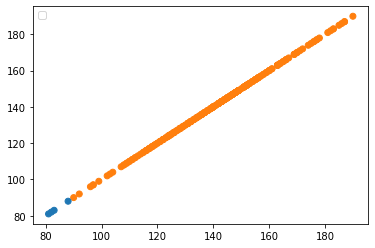

array: 3


No handles with labels found to put in legend.


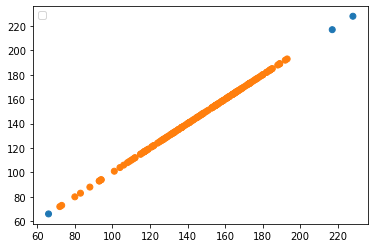

array: 4


No handles with labels found to put in legend.


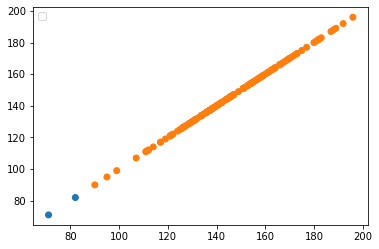

No handles with labels found to put in legend.


array: 5


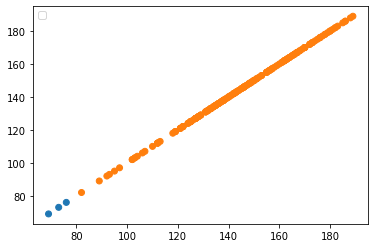

No handles with labels found to put in legend.


array: 6


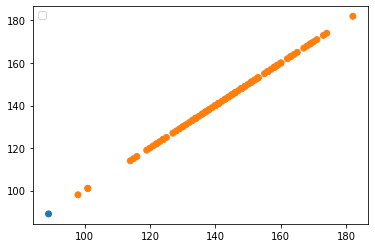

No handles with labels found to put in legend.


array: 7


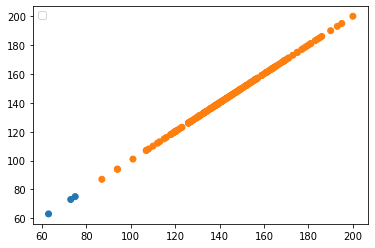

No handles with labels found to put in legend.


array: 8


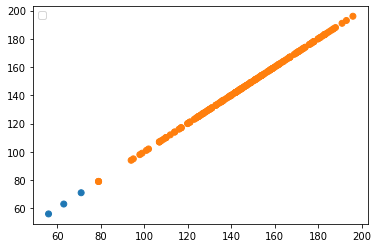

array: 9


No handles with labels found to put in legend.


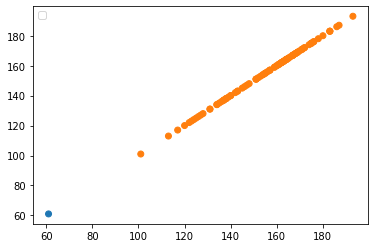

array: 10


No handles with labels found to put in legend.


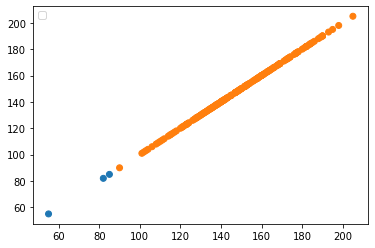

array: 11


No handles with labels found to put in legend.


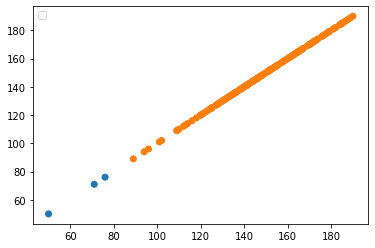

No handles with labels found to put in legend.


array: 12


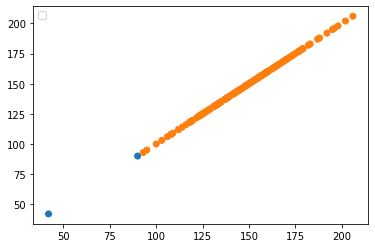

array: 13


No handles with labels found to put in legend.


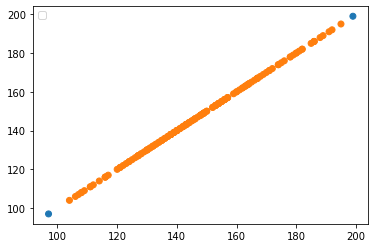

No handles with labels found to put in legend.


array: 14


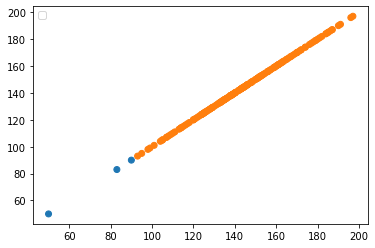

array: 15


No handles with labels found to put in legend.


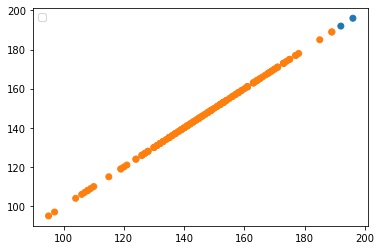

No handles with labels found to put in legend.


array: 16


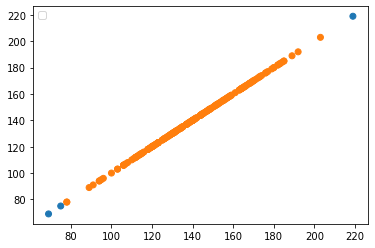

No handles with labels found to put in legend.


array: 17


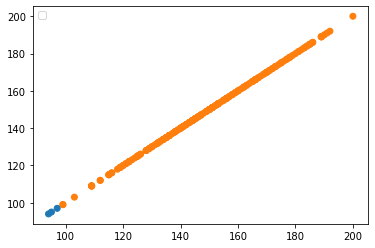

No handles with labels found to put in legend.


array: 18


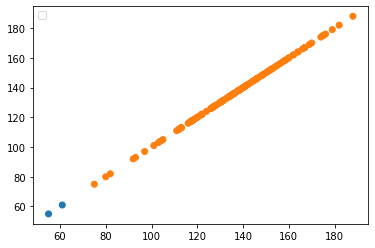

No handles with labels found to put in legend.


array: 19


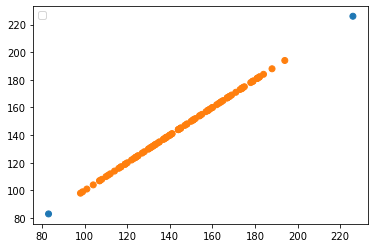

No handles with labels found to put in legend.


array: 20


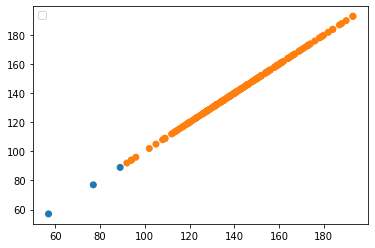

No handles with labels found to put in legend.


array: 21


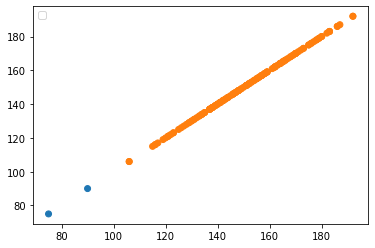

No handles with labels found to put in legend.


array: 22


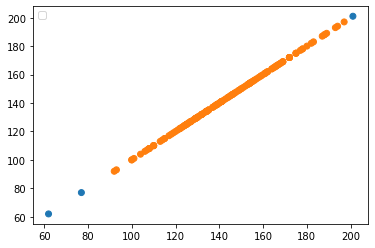

array: 23


No handles with labels found to put in legend.


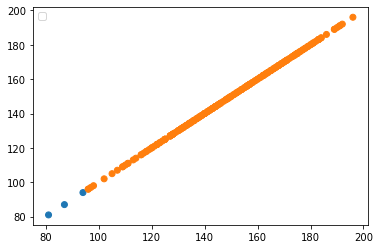

array: 

No handles with labels found to put in legend.


24


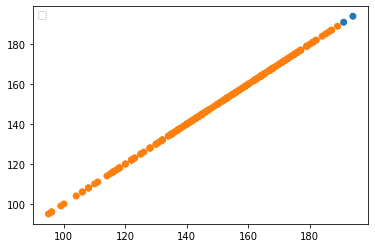

No handles with labels found to put in legend.


array: 25


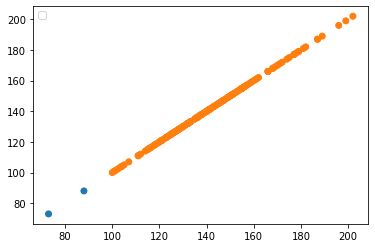

No handles with labels found to put in legend.


array: 26


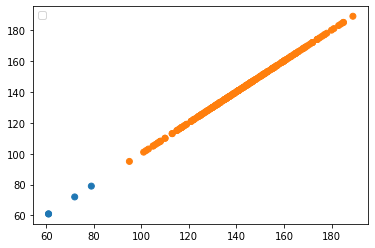

array: 27


No handles with labels found to put in legend.


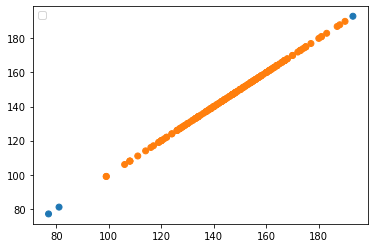

No handles with labels found to put in legend.


array: 28


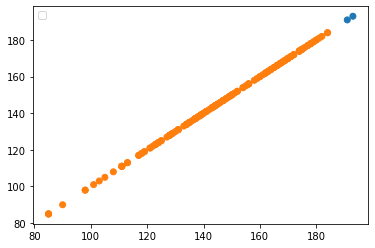

array: 29


No handles with labels found to put in legend.


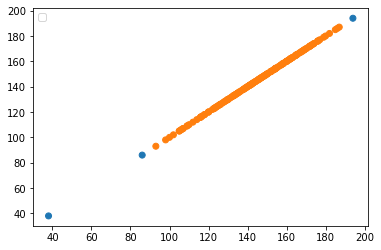

No handles with labels found to put in legend.


array: 30


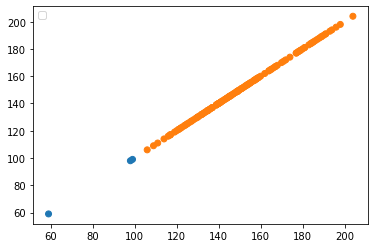

No handles with labels found to put in legend.


array: 31


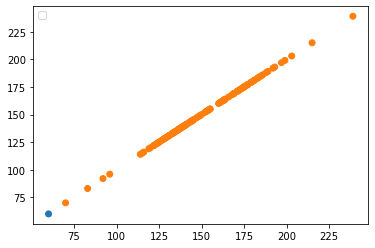

array: 32


No handles with labels found to put in legend.


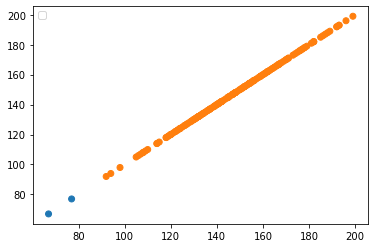

No handles with labels found to put in legend.


array: 33


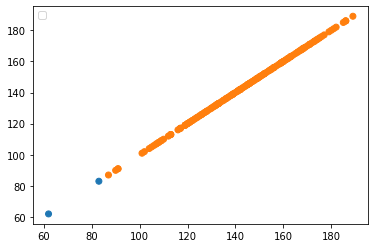

array: 34


No handles with labels found to put in legend.


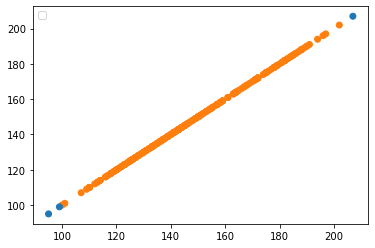

No handles with labels found to put in legend.


array: 35


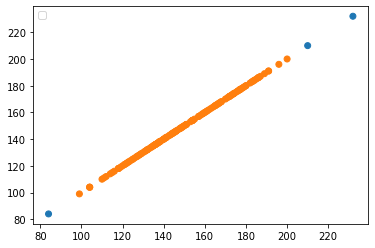

array: 36


No handles with labels found to put in legend.


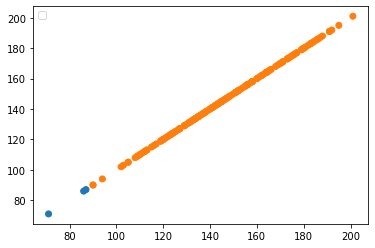

array: 37


No handles with labels found to put in legend.


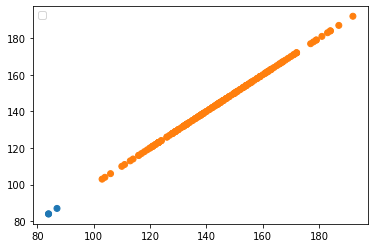

No handles with labels found to put in legend.


array: 38


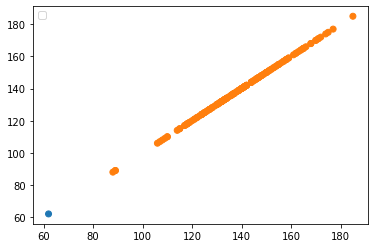

No handles with labels found to put in legend.


array: 39


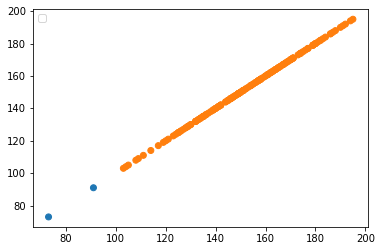

No handles with labels found to put in legend.


array: 40


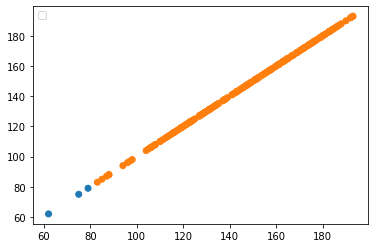

array: 41


No handles with labels found to put in legend.


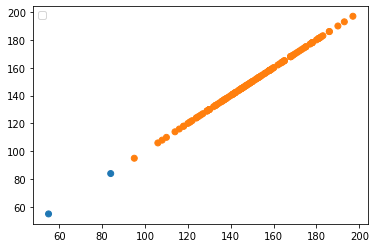

No handles with labels found to put in legend.


array: 42


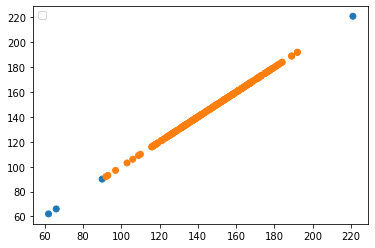

No handles with labels found to put in legend.


array: 43


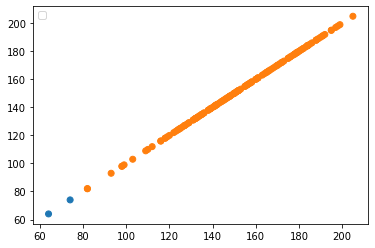

No handles with labels found to put in legend.


array: 44


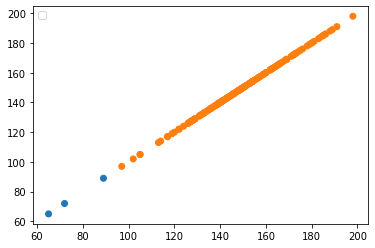

array:

No handles with labels found to put in legend.


 45


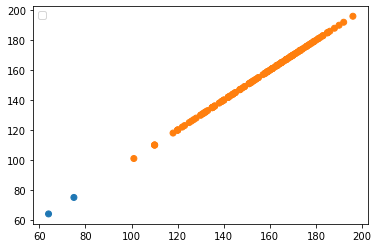

array: 46


No handles with labels found to put in legend.


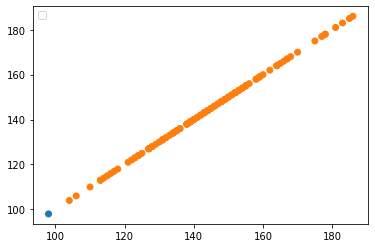

No handles with labels found to put in legend.


array: 47


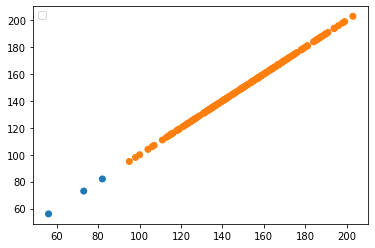

No handles with labels found to put in legend.


array: 48


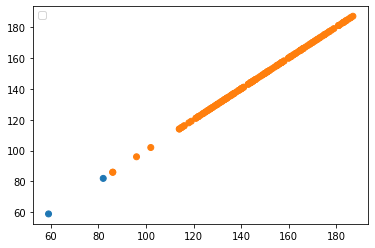

array: 49


No handles with labels found to put in legend.


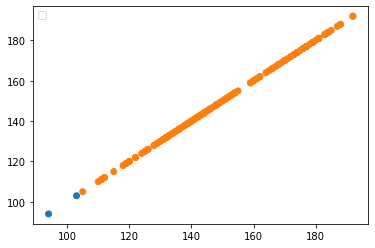

No handles with labels found to put in legend.


array: 50


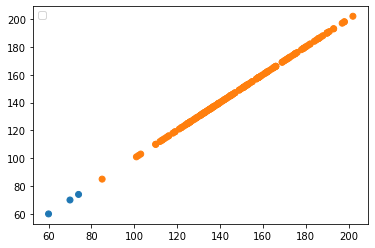

No handles with labels found to put in legend.


array: 51


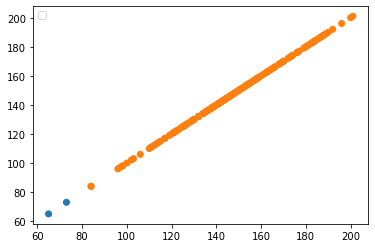

array: 52


No handles with labels found to put in legend.


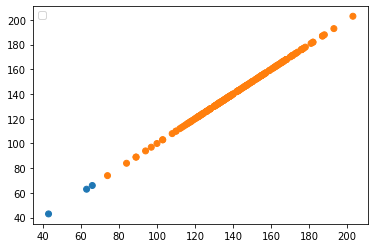

No handles with labels found to put in legend.


array: 53


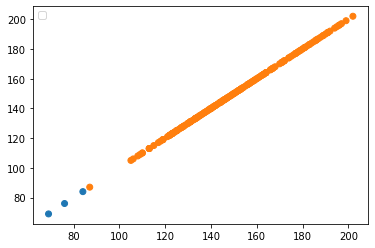

array: 54


No handles with labels found to put in legend.


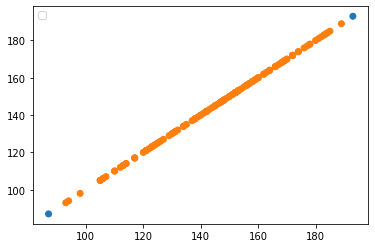

No handles with labels found to put in legend.


array: 55


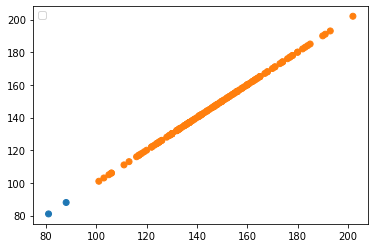

No handles with labels found to put in legend.


array: 56


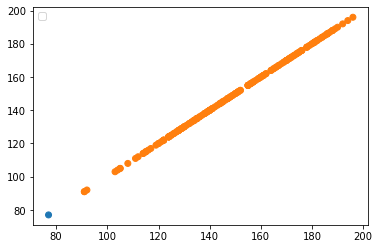

array: 57


No handles with labels found to put in legend.


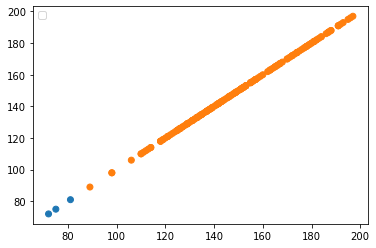

No handles with labels found to put in legend.


array: 58


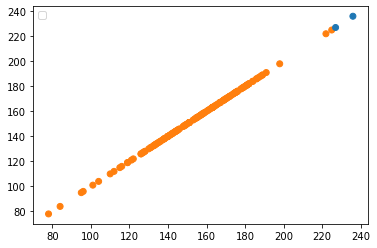

array:

No handles with labels found to put in legend.


 59


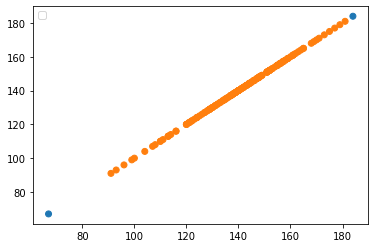

array: 60


No handles with labels found to put in legend.


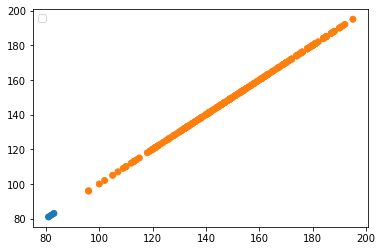

No handles with labels found to put in legend.


array: 61


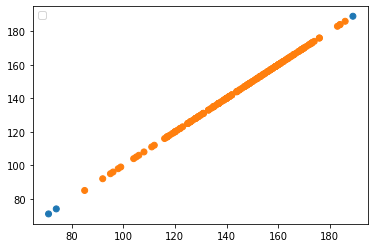

No handles with labels found to put in legend.


array: 62


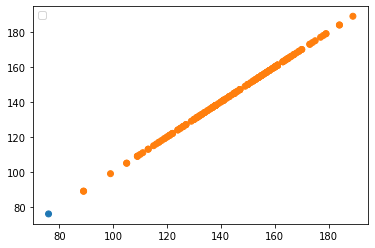

No handles with labels found to put in legend.


array: 63


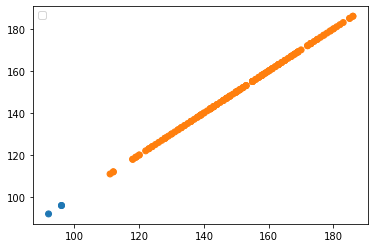

No handles with labels found to put in legend.


array: 64


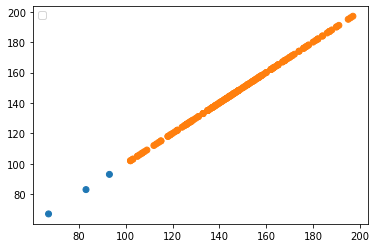

array: 65


No handles with labels found to put in legend.


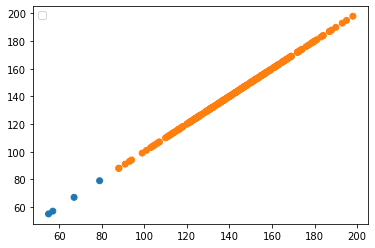

No handles with labels found to put in legend.


array: 66


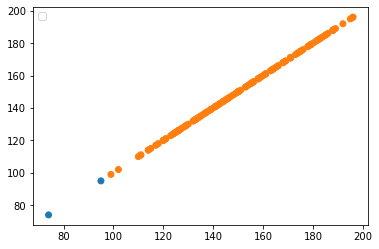

array: 67


No handles with labels found to put in legend.


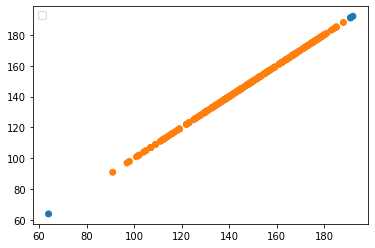

No handles with labels found to put in legend.


array: 68


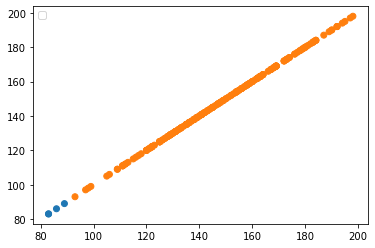

No handles with labels found to put in legend.


array: 69


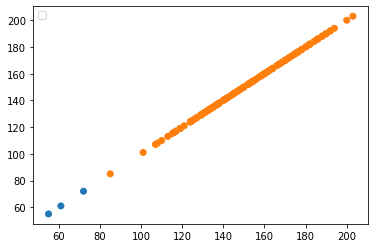

array: 70


No handles with labels found to put in legend.


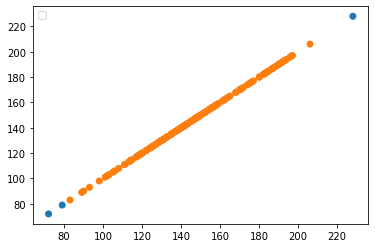

No handles with labels found to put in legend.


array: 71


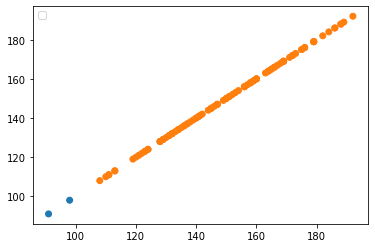

No handles with labels found to put in legend.


array: 72


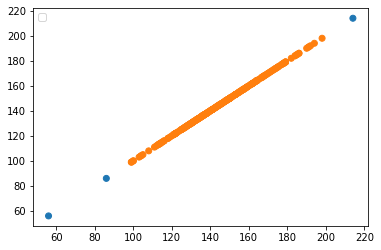

No handles with labels found to put in legend.


array: 73


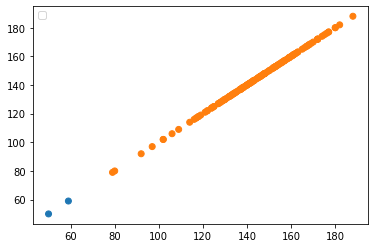

array:

No handles with labels found to put in legend.


 74


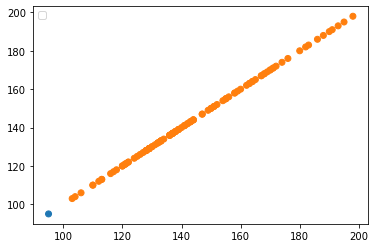

No handles with labels found to put in legend.


array: 75


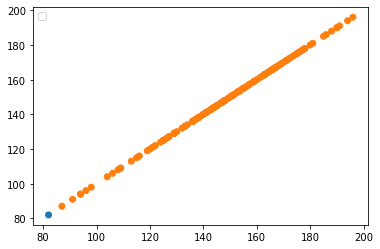

No handles with labels found to put in legend.


array: 76


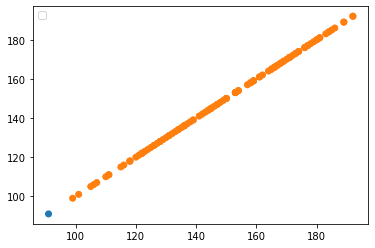

No handles with labels found to put in legend.


array: 77


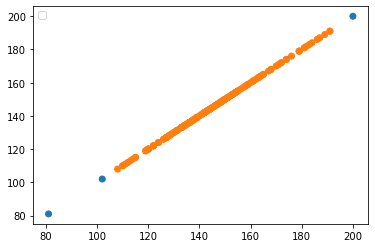

No handles with labels found to put in legend.


array: 78


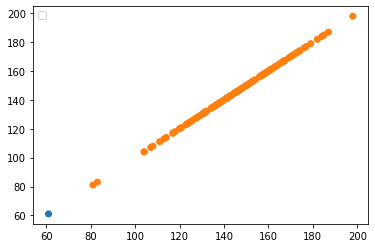

array: 79


No handles with labels found to put in legend.


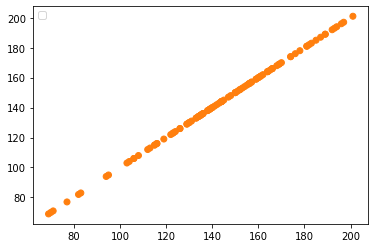

array: 80


No handles with labels found to put in legend.


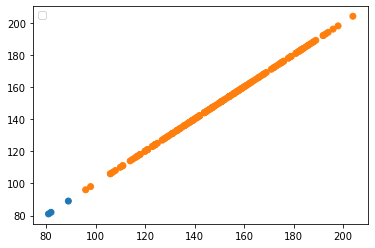

No handles with labels found to put in legend.


array: 81


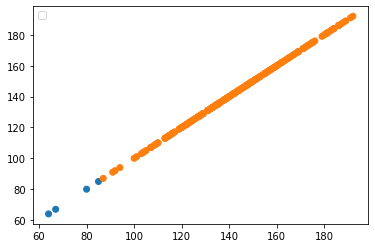

array: 82


No handles with labels found to put in legend.


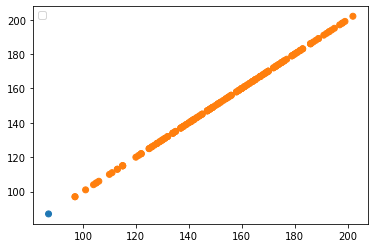

No handles with labels found to put in legend.


array: 83


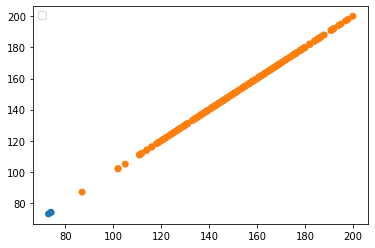

No handles with labels found to put in legend.


array: 84


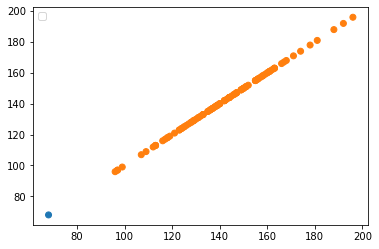

array: 85


No handles with labels found to put in legend.


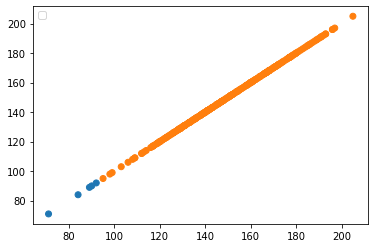

No handles with labels found to put in legend.


array: 86


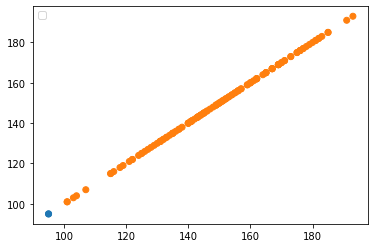

No handles with labels found to put in legend.


array: 87


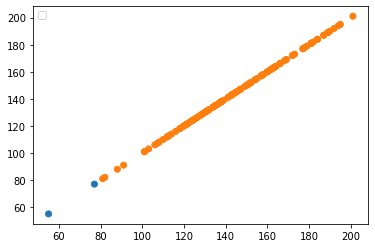

No handles with labels found to put in legend.


array: 88


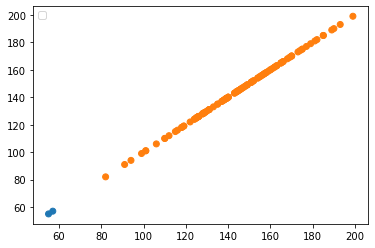

array: 89


No handles with labels found to put in legend.


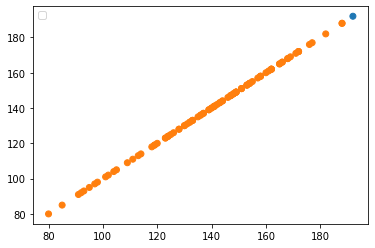

No handles with labels found to put in legend.


array: 90


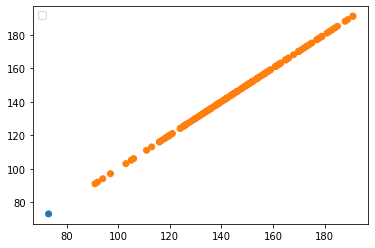

No handles with labels found to put in legend.


array: 91


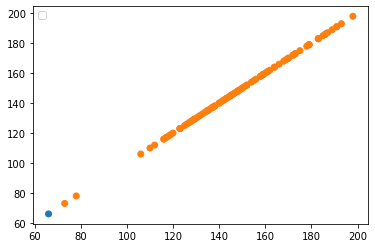

No handles with labels found to put in legend.


array: 92


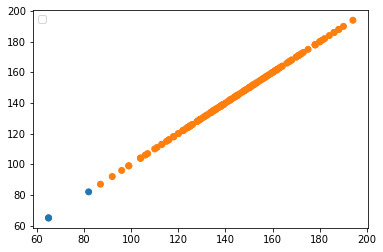

array: 93


No handles with labels found to put in legend.


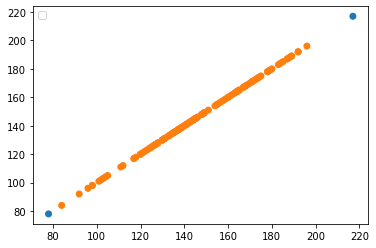

array: 94


No handles with labels found to put in legend.


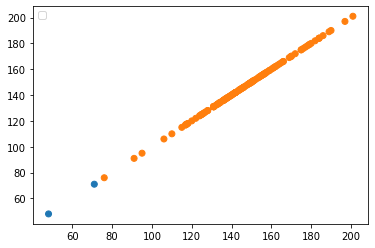

array: 95


No handles with labels found to put in legend.


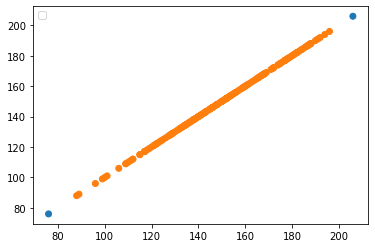

array: 96


No handles with labels found to put in legend.


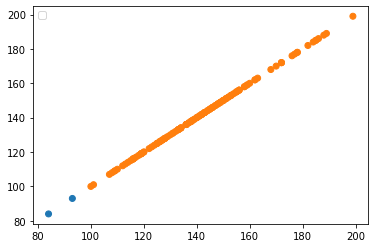

No handles with labels found to put in legend.


array: 97


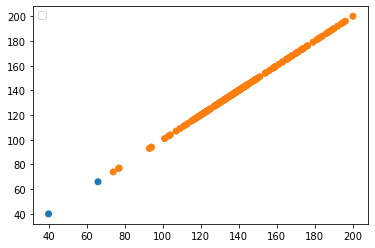

No handles with labels found to put in legend.


array: 98


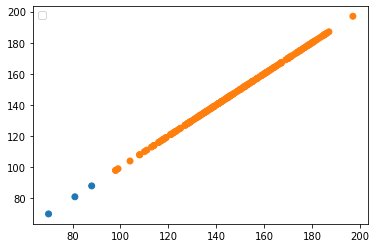

No handles with labels found to put in legend.


array: 99


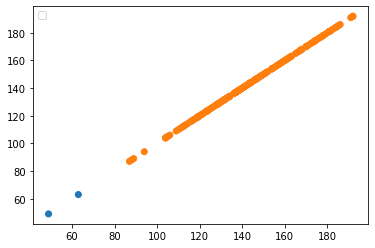

No handles with labels found to put in legend.


array: 100


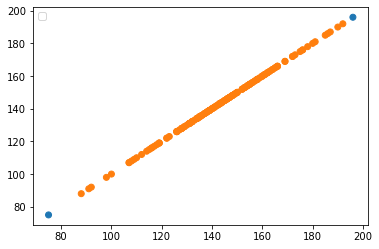

array: 101


No handles with labels found to put in legend.


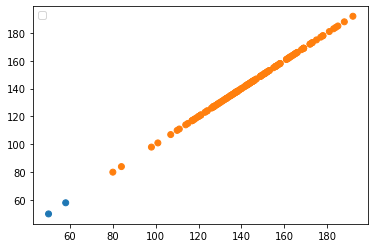

No handles with labels found to put in legend.


array: 102


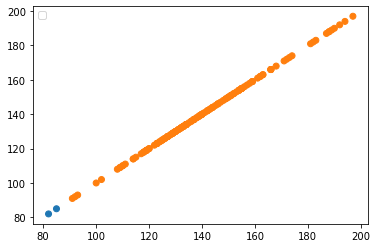

array: 103


No handles with labels found to put in legend.


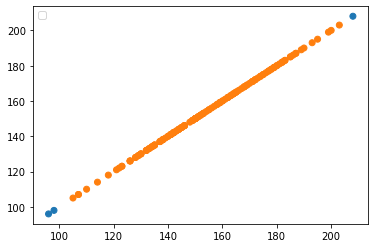

No handles with labels found to put in legend.


array: 104


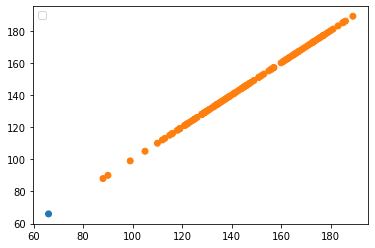

No handles with labels found to put in legend.


array: 105


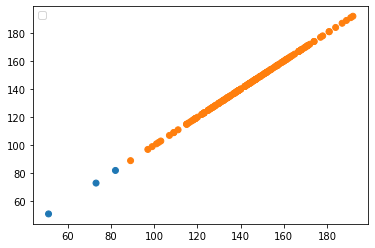

array: 106


No handles with labels found to put in legend.


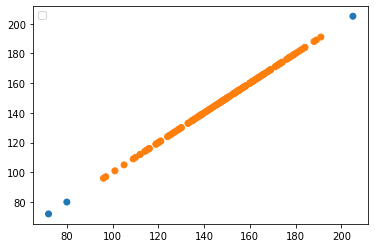

array: 107


No handles with labels found to put in legend.


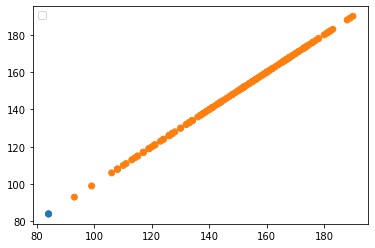

No handles with labels found to put in legend.


array: 108


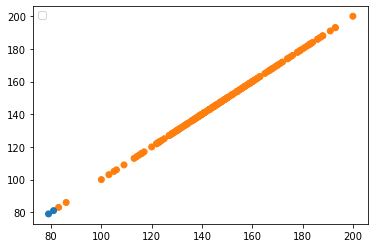

No handles with labels found to put in legend.


array: 109


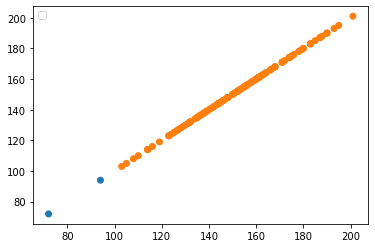

array: 110


No handles with labels found to put in legend.


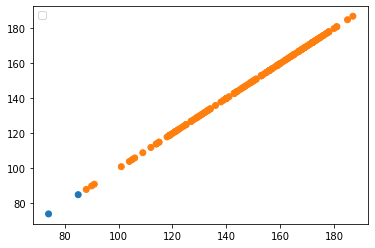

No handles with labels found to put in legend.


array: 111


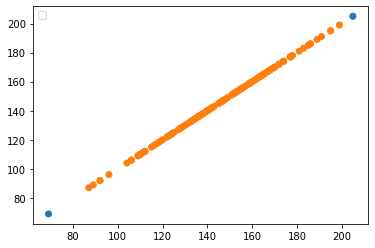

No handles with labels found to put in legend.


array: 112


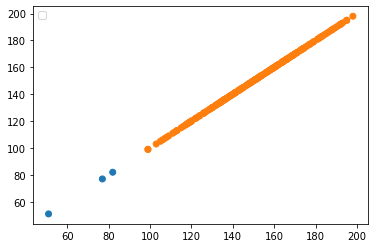

array: 113


No handles with labels found to put in legend.


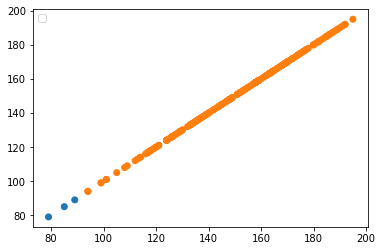

No handles with labels found to put in legend.


array: 114


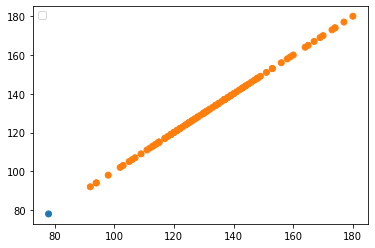

No handles with labels found to put in legend.


array: 115


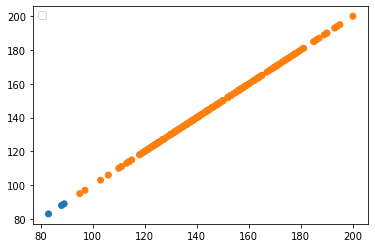

No handles with labels found to put in legend.


array: 116


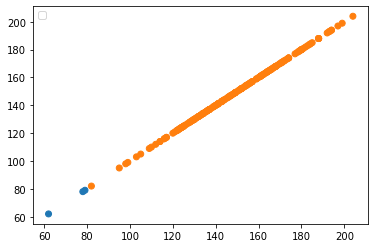

array: 117


No handles with labels found to put in legend.


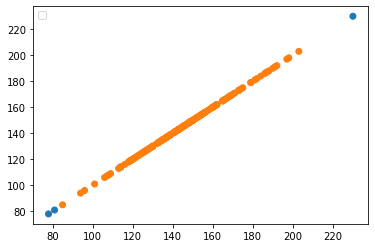

array: 118


No handles with labels found to put in legend.


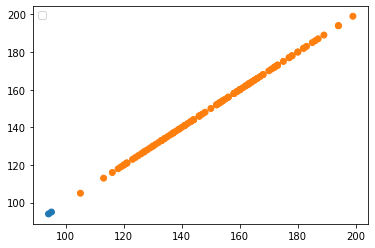

array: 119


No handles with labels found to put in legend.


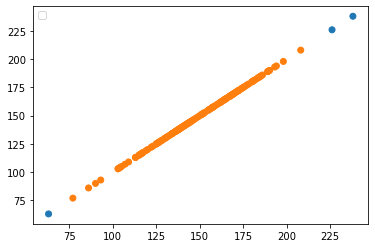

No handles with labels found to put in legend.


array: 120


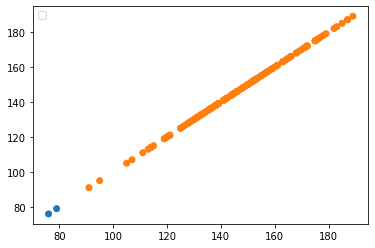

No handles with labels found to put in legend.


array: 121


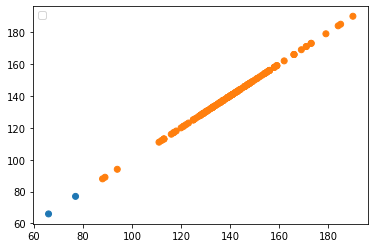

No handles with labels found to put in legend.


array: 122


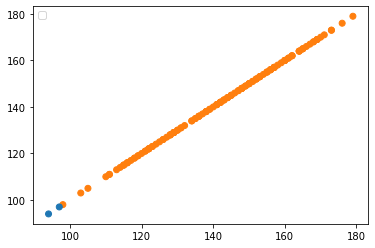

No handles with labels found to put in legend.


array: 123


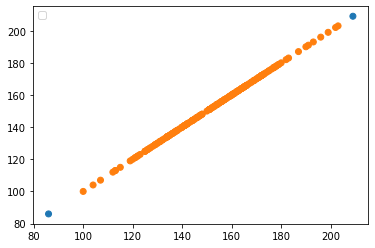

No handles with labels found to put in legend.


array: 124


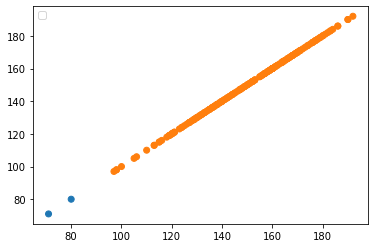

array: 125


No handles with labels found to put in legend.


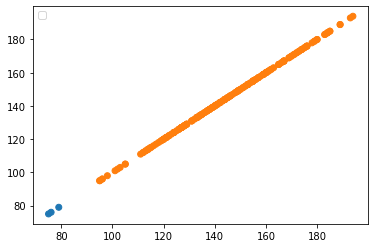

No handles with labels found to put in legend.


array: 126


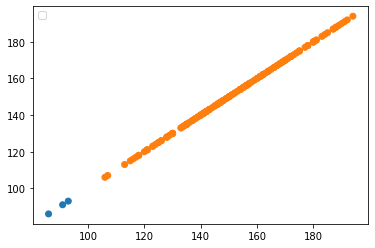

No handles with labels found to put in legend.


array: 127


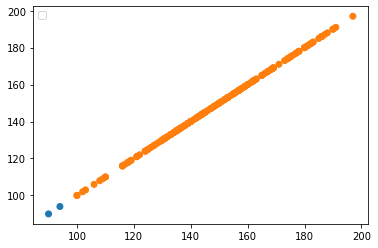

array: 128


No handles with labels found to put in legend.


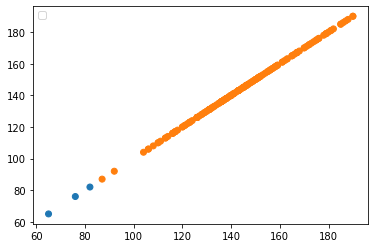

No handles with labels found to put in legend.


array: 129


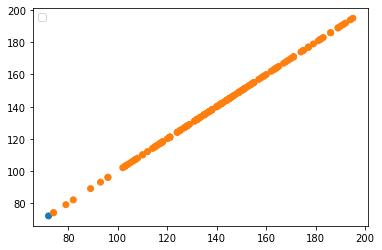

array: 130


No handles with labels found to put in legend.


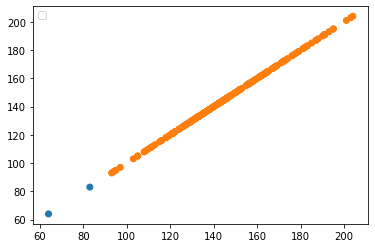

array: 131


No handles with labels found to put in legend.


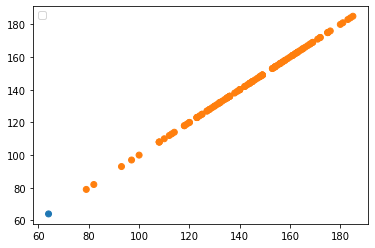

array: 132


No handles with labels found to put in legend.


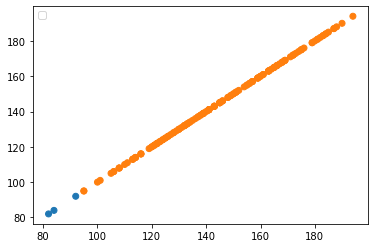

No handles with labels found to put in legend.


array: 133


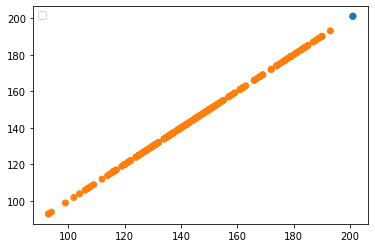

No handles with labels found to put in legend.


array: 134


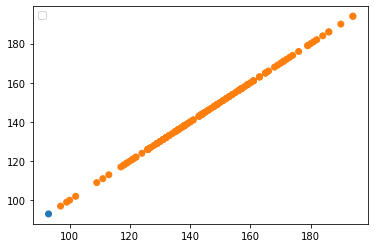

No handles with labels found to put in legend.


array: 135


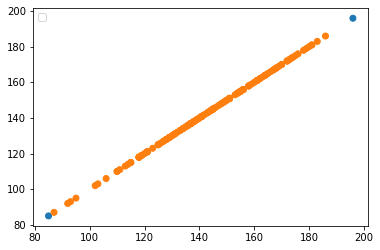

No handles with labels found to put in legend.


array: 136


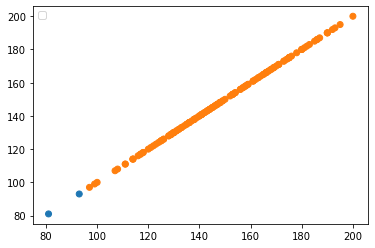

array: 137


No handles with labels found to put in legend.


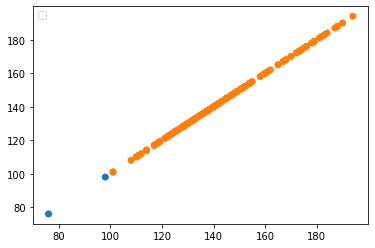

No handles with labels found to put in legend.


array: 138


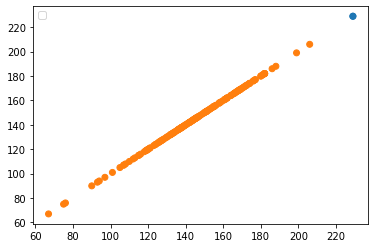

array: 139


No handles with labels found to put in legend.


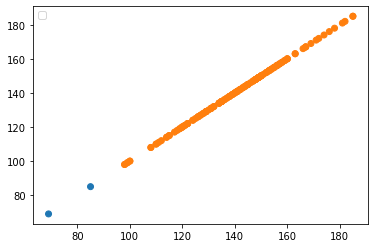

array: 140


No handles with labels found to put in legend.


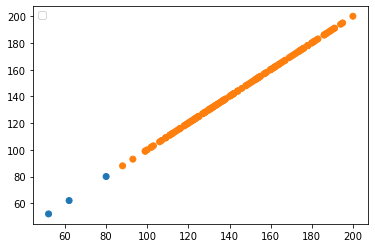

No handles with labels found to put in legend.


array: 141


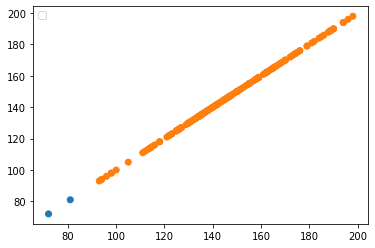

array: 142


No handles with labels found to put in legend.


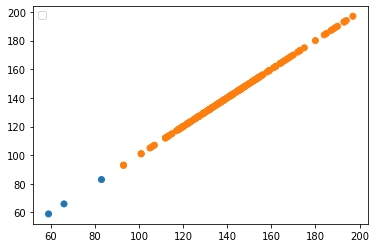

No handles with labels found to put in legend.


array: 143


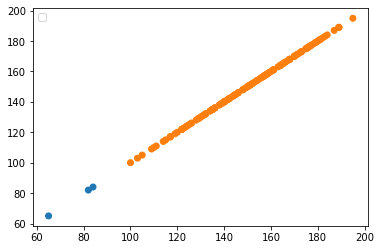

array: 144


No handles with labels found to put in legend.


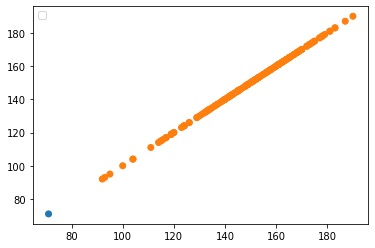

No handles with labels found to put in legend.


array: 145


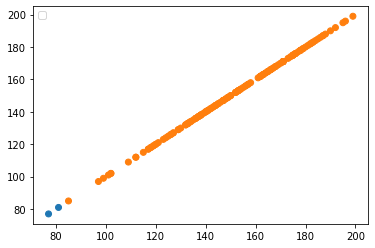

array: 146


No handles with labels found to put in legend.


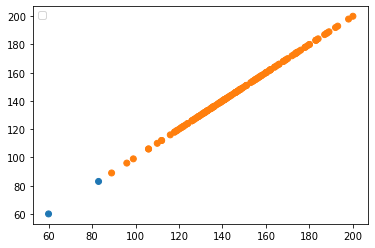

array: 147


No handles with labels found to put in legend.


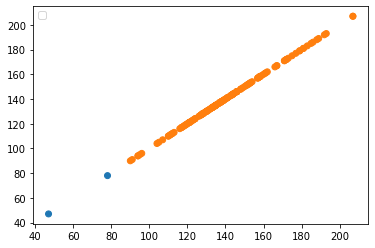

No handles with labels found to put in legend.


array: 148


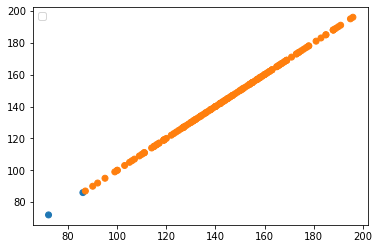

array: 149


No handles with labels found to put in legend.


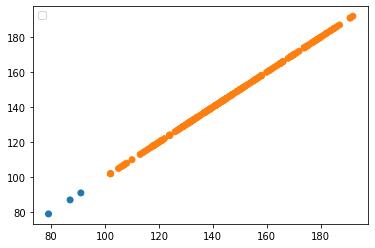

No handles with labels found to put in legend.


array: 150


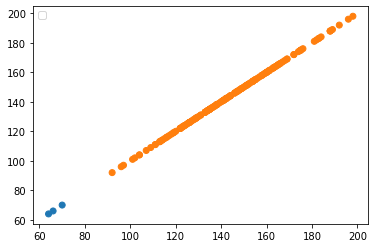

No handles with labels found to put in legend.


array: 151


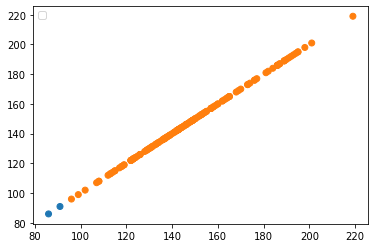

array: 152


No handles with labels found to put in legend.


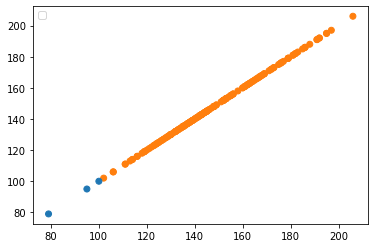

array: 153


No handles with labels found to put in legend.


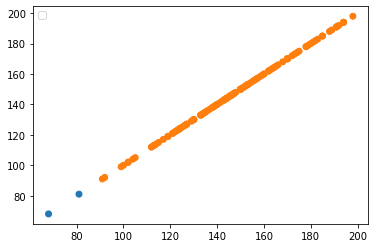

No handles with labels found to put in legend.


array: 154


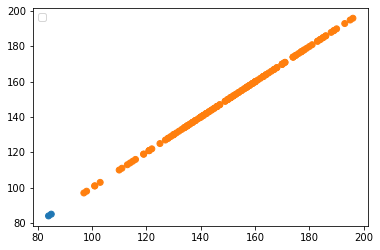

No handles with labels found to put in legend.


array: 155


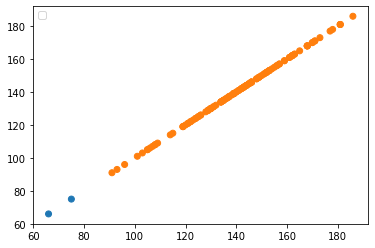

array: 156


No handles with labels found to put in legend.


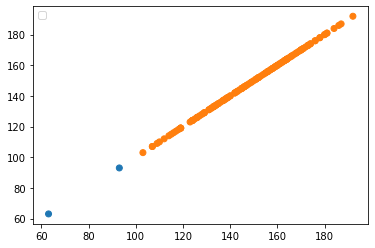

No handles with labels found to put in legend.


array: 157


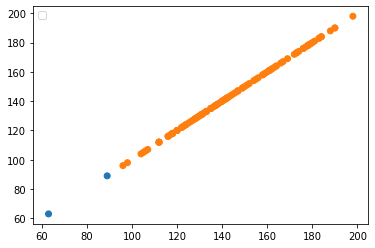

array: 158


No handles with labels found to put in legend.


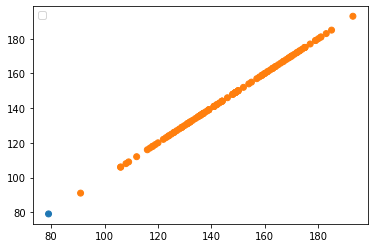

No handles with labels found to put in legend.


array: 159


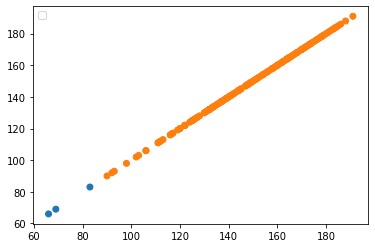

array: 160


No handles with labels found to put in legend.


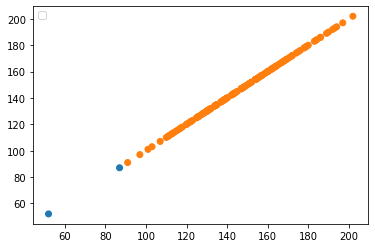

No handles with labels found to put in legend.


array: 161


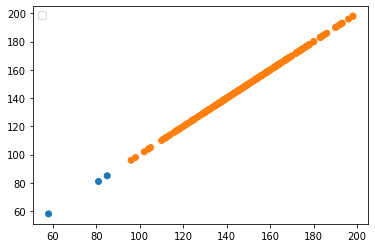

No handles with labels found to put in legend.


array: 162


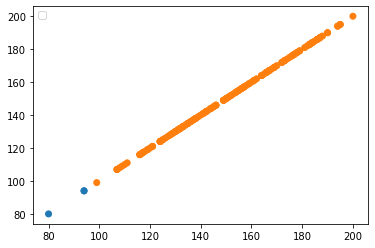

No handles with labels found to put in legend.


array: 163


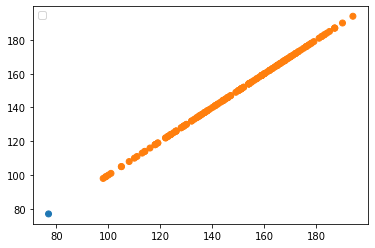

No handles with labels found to put in legend.


array: 164


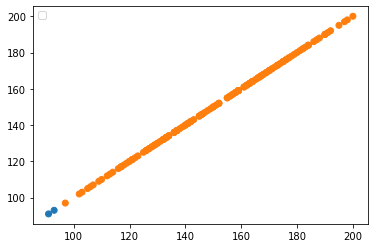

No handles with labels found to put in legend.


array: 165


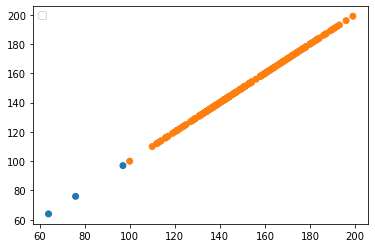

array: 166


No handles with labels found to put in legend.


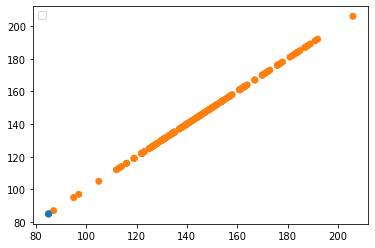

array: 167


No handles with labels found to put in legend.


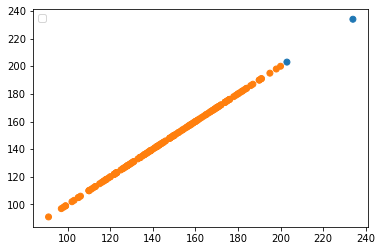

No handles with labels found to put in legend.


array: 168


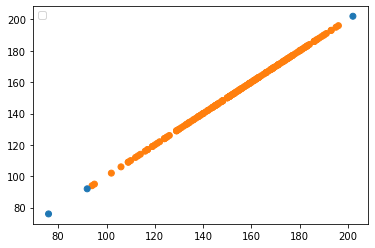

array: 169


No handles with labels found to put in legend.


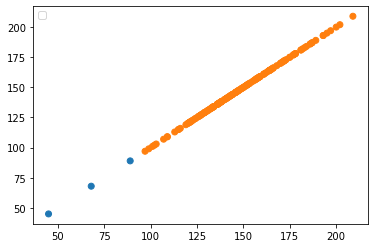

array: 170


No handles with labels found to put in legend.


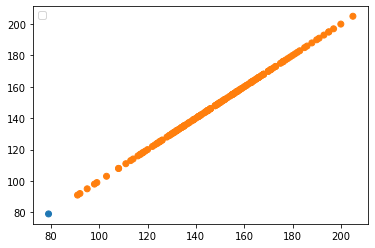

No handles with labels found to put in legend.


array: 171


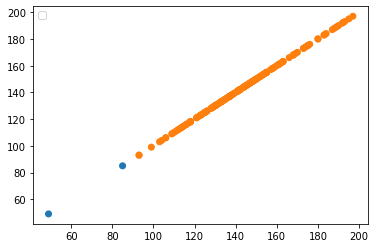

array: 172


No handles with labels found to put in legend.


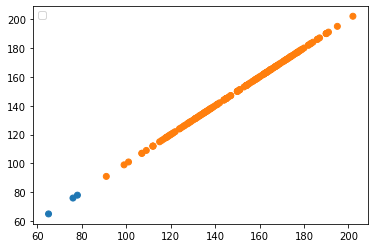

No handles with labels found to put in legend.


array: 173


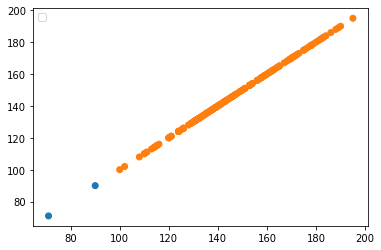

array:

No handles with labels found to put in legend.


 174


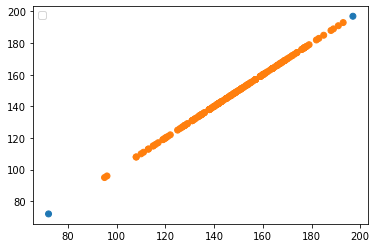

array: 175


No handles with labels found to put in legend.


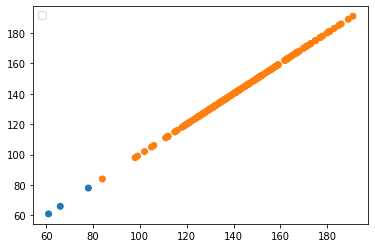

No handles with labels found to put in legend.


array: 176


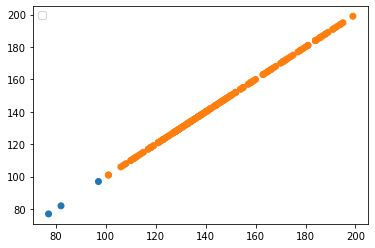

No handles with labels found to put in legend.


array: 177


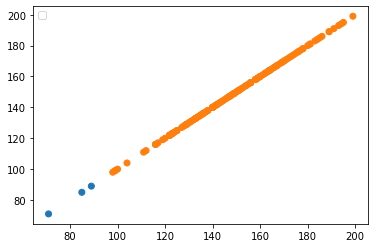

array: 178


No handles with labels found to put in legend.


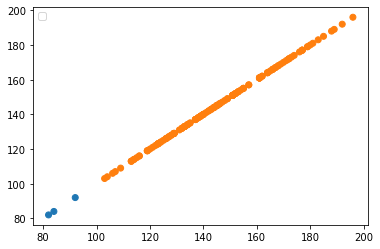

array: 179


No handles with labels found to put in legend.


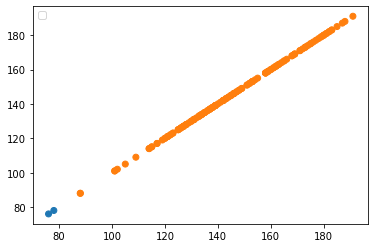

No handles with labels found to put in legend.


array: 180


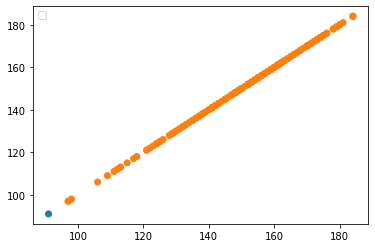

No handles with labels found to put in legend.


array: 181


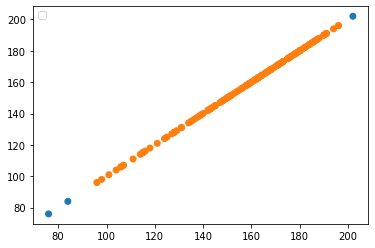

No handles with labels found to put in legend.


array: 182


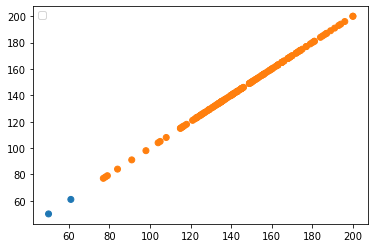

array: 183


No handles with labels found to put in legend.


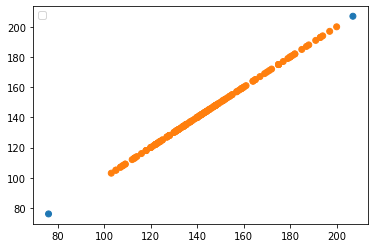

No handles with labels found to put in legend.


array: 184


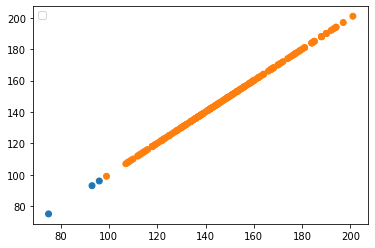

No handles with labels found to put in legend.


array: 185


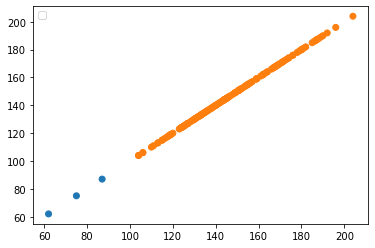

array: 186


No handles with labels found to put in legend.


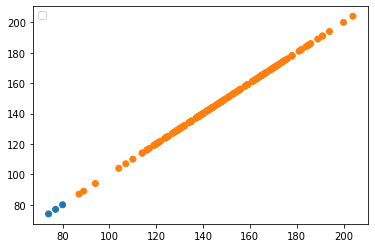

array: 187


No handles with labels found to put in legend.


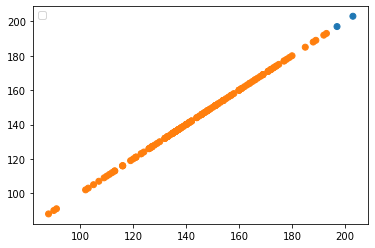

No handles with labels found to put in legend.


array: 188


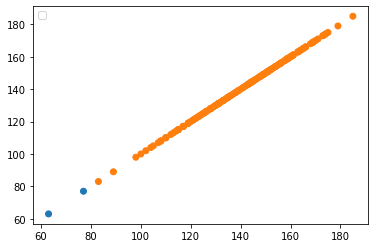

No handles with labels found to put in legend.


array: 189


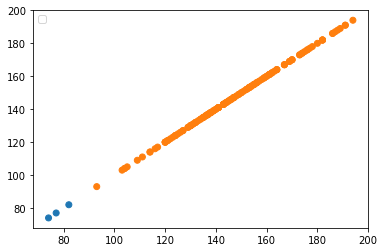

array: 190


No handles with labels found to put in legend.


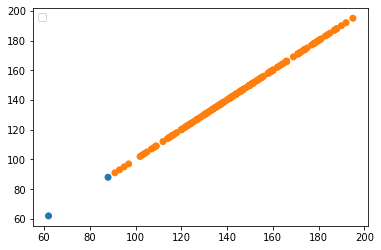

array: 191


No handles with labels found to put in legend.


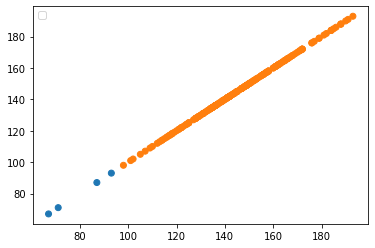

No handles with labels found to put in legend.


array: 192


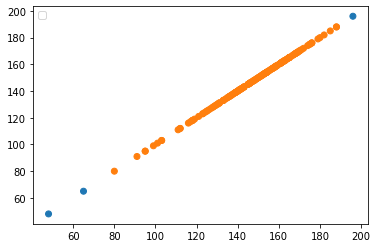

array: 193


No handles with labels found to put in legend.


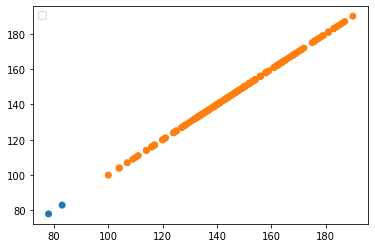

array: 194


No handles with labels found to put in legend.


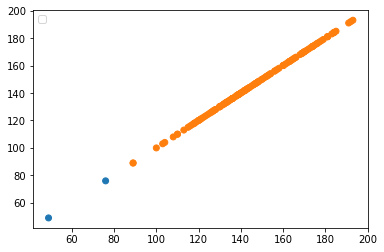

No handles with labels found to put in legend.


array: 195


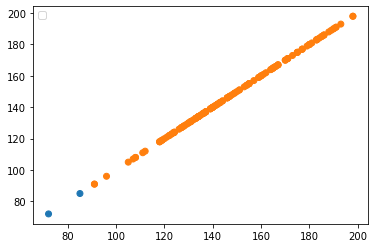

array: 196


No handles with labels found to put in legend.


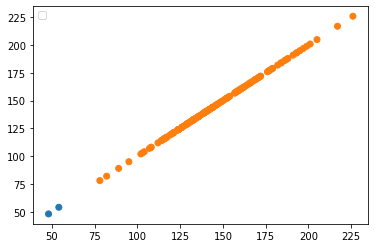

array: 197


No handles with labels found to put in legend.


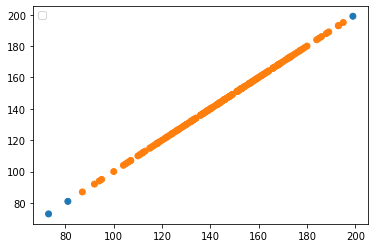

array: 198


No handles with labels found to put in legend.


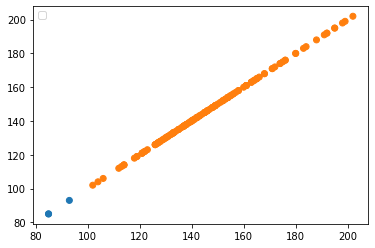

No handles with labels found to put in legend.


array: 199


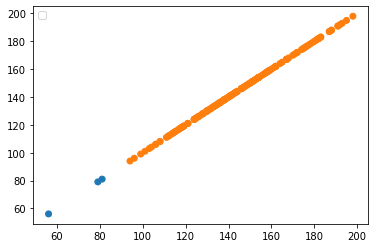

array: 200


No handles with labels found to put in legend.


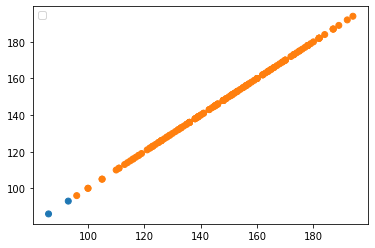

array: 201


No handles with labels found to put in legend.


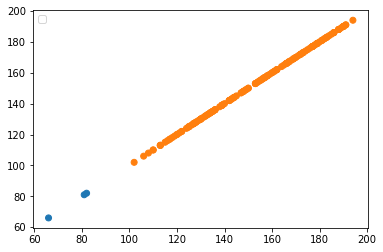

No handles with labels found to put in legend.


array: 202


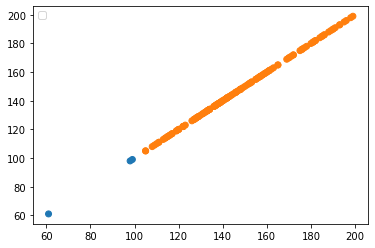

No handles with labels found to put in legend.


array: 203


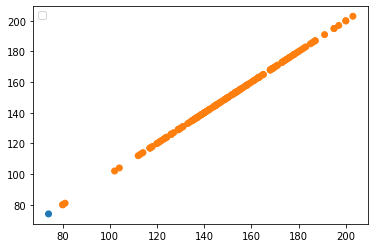

array: 204


No handles with labels found to put in legend.


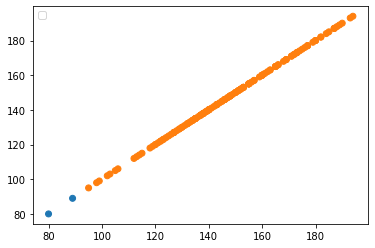

No handles with labels found to put in legend.


array: 205


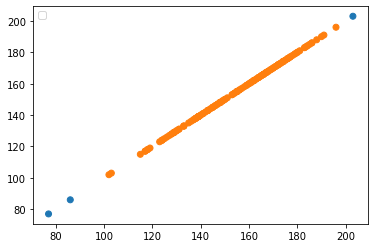

No handles with labels found to put in legend.


array: 206


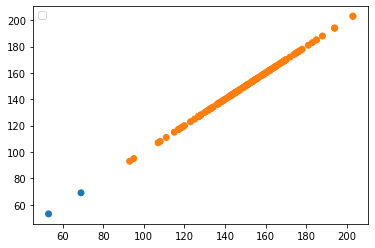

array: 207


No handles with labels found to put in legend.


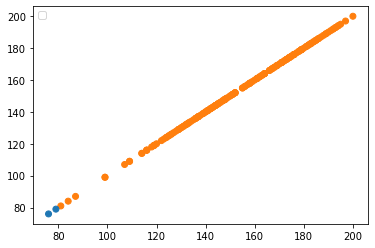

array: 208


No handles with labels found to put in legend.


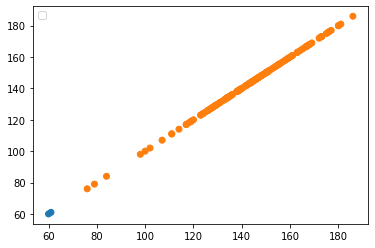

array: 209


No handles with labels found to put in legend.


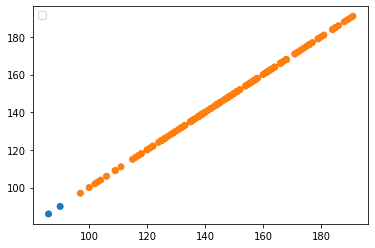

No handles with labels found to put in legend.


array: 210


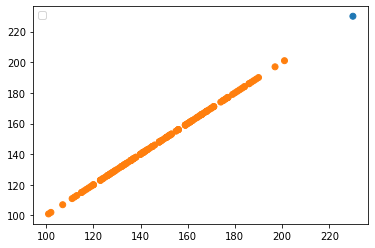

No handles with labels found to put in legend.


array: 211


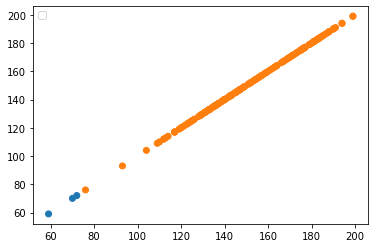

No handles with labels found to put in legend.


array: 212


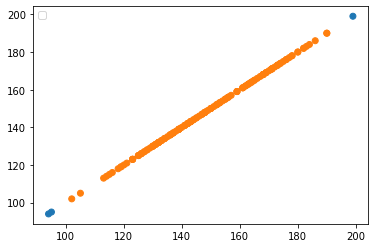

No handles with labels found to put in legend.


array: 213


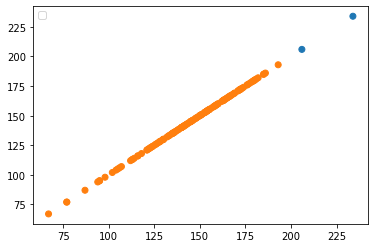

No handles with labels found to put in legend.


array: 214


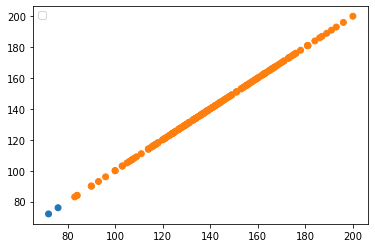

array: 215


No handles with labels found to put in legend.


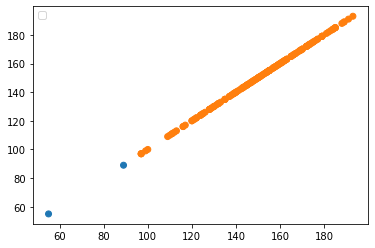

No handles with labels found to put in legend.


array: 216


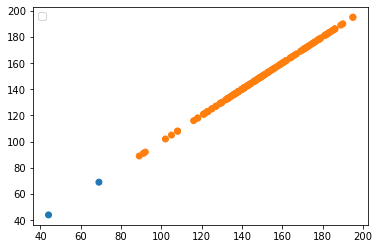

No handles with labels found to put in legend.


array: 217


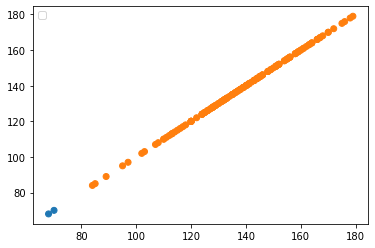

No handles with labels found to put in legend.


array: 218


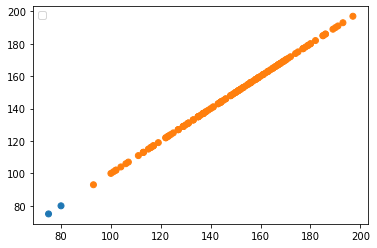

No handles with labels found to put in legend.


array: 219


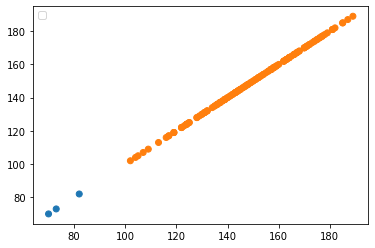

array: 220


No handles with labels found to put in legend.


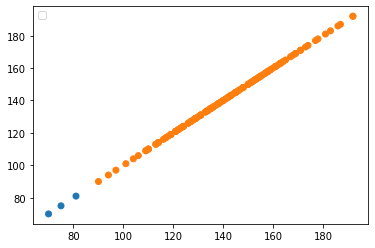

No handles with labels found to put in legend.


array: 221


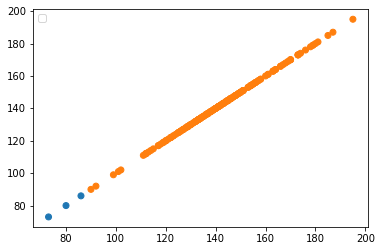

No handles with labels found to put in legend.


array: 222


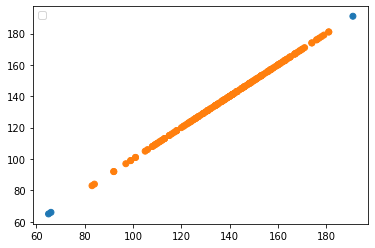

No handles with labels found to put in legend.


array: 223


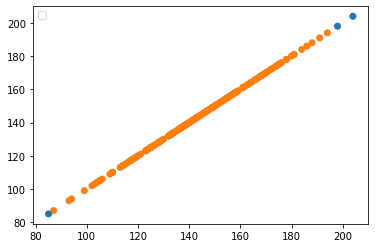

No handles with labels found to put in legend.


array: 224


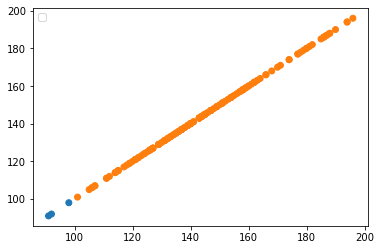

No handles with labels found to put in legend.


array: 225


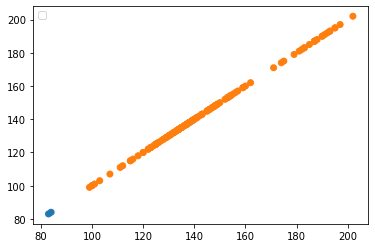

array: 226


No handles with labels found to put in legend.


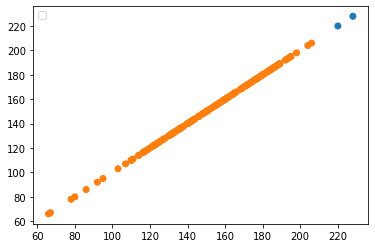

No handles with labels found to put in legend.


array: 227


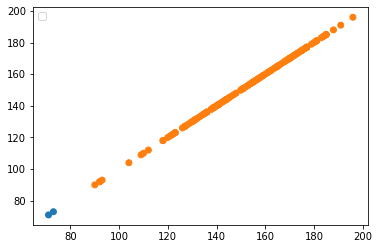

No handles with labels found to put in legend.


array: 228


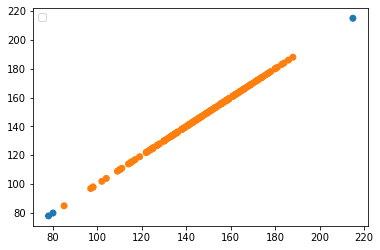

array: 229


No handles with labels found to put in legend.


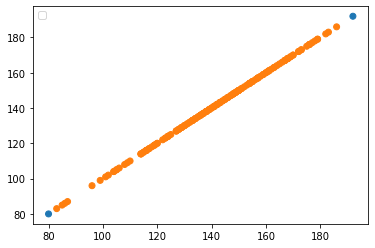

No handles with labels found to put in legend.


array: 230


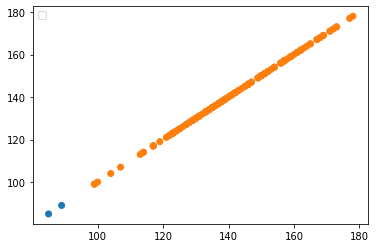

No handles with labels found to put in legend.


array: 231


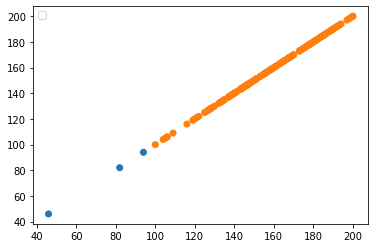

array: 232


No handles with labels found to put in legend.


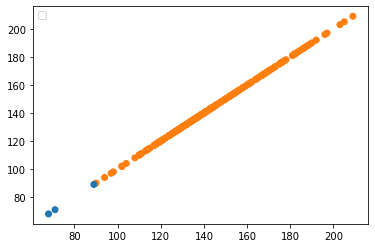

No handles with labels found to put in legend.


array: 233


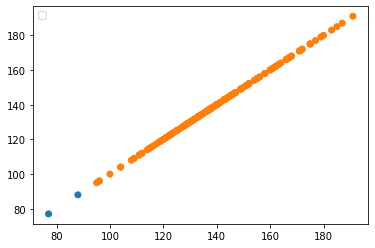

No handles with labels found to put in legend.


array: 234


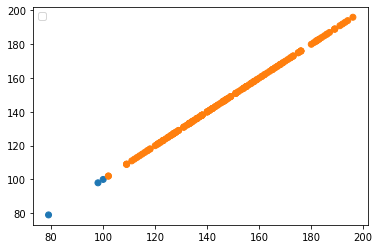

No handles with labels found to put in legend.


array: 235


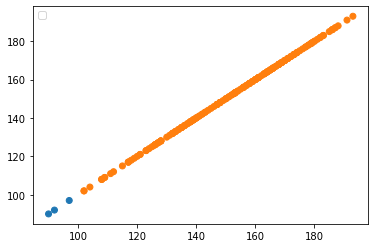

In [21]:
cmap = plt.get_cmap("tab20")
for c in range(0,max(module_labels)+1):
    print("array:", c)
    fig, ax = plt.subplots(facecolor="w")
    data = array_clusters_temperature[c]
    pred = array_clf[c].predict(data)
    plt.scatter(data[:, 0], data[:, 1], color=cmap(pred+1))
    ax.legend(loc='upper left')
    plt.show()

In [22]:
#for k, v in data_array.items():
#    print("module label:",k)
#    display.display_distributions(v.all_temperature, 
#                              filepath = "hist_all_temperature.jpg")
#    display.display_distributions(v.scaled_all_temperature, 
#                              filepath = "hist_scaled_all_temperature.jpg")        
#    display.display_distributions(array_scaler[k].transform(v.all_temperature), 
#                              filepath = "hist_transformed_all_temperature.jpg")

異常タイプの確認テスト

In [23]:
def get_hotspots_in_array(transformed_clusters_temperature, img_file, log=False):
    # -- hot cluster --
    hot_clusters = (transformed_clusters_temperature.mean(axis=1) > 2.0)
    # -- hot pixcel --
    hot_pixels = np.array([c in np.where(hot_clusters==True)[0] for c in clusters.labels])
    hot_pixels = hot_pixels.reshape(*img_file.shape[:2],1)      
    if log:
        print("Hot cluster labels in array:",hot_clusters)
        print("Hotspot weights in array:",hot_pixels.mean())
    return hot_pixels, hot_clusters

In [24]:
def get_hotspots_in_module(
    scaled_clusters_temperature, transformed_clusters_temperature, img_file, log=False):
    # -- hot cluster --
    hot_clusters = (scaled_clusters_temperature.mean(axis=1) > 3.0) \
    & (transformed_clusters_temperature.mean(axis=1) > 0)
    # -- hot pixcel --
    hot_pixels = np.array([c in np.where(hot_clusters==True)[0] for c in clusters.labels])
    hot_pixels = hot_pixels.reshape(*img_file.shape[:2],1)      
    if log:
        print("Hot cluster labels in module:",hot_clusters)
        print("Hotspot weights in module:",hot_pixels.mean())
    return hot_pixels, hot_clusters

In [25]:
def get_hotspots_lof(
    original_clusters_temperature, transformed_clusters_temperature, img_file, log=False):
    hot_clusters = (array_clf[l].predict(original_clusters_temperature) < 0) \
    & (transformed_clusters_temperature.mean(axis=1) > 0)
    hot_pixels = np.array([c in np.where(hot_clusters==True)[0] for c in clusters.labels])
    hot_pixels = hot_pixels.reshape(*img_file.shape[:2],1) 
    return hot_pixels, hot_clusters

3752.jpg Single-Hotspot


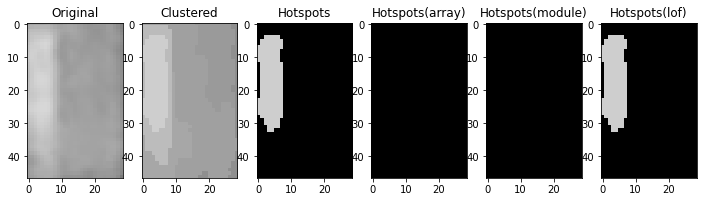

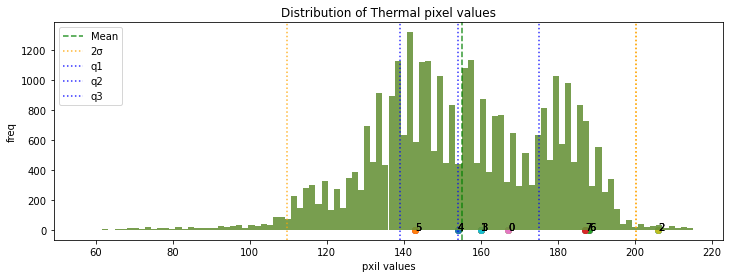

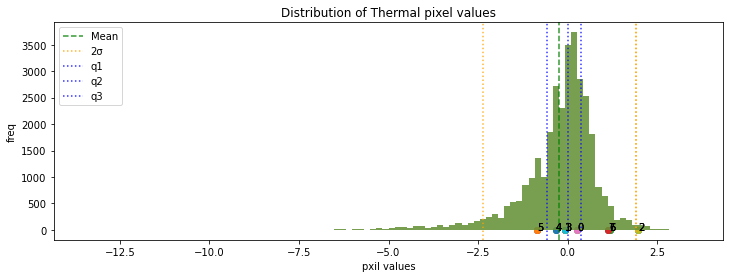

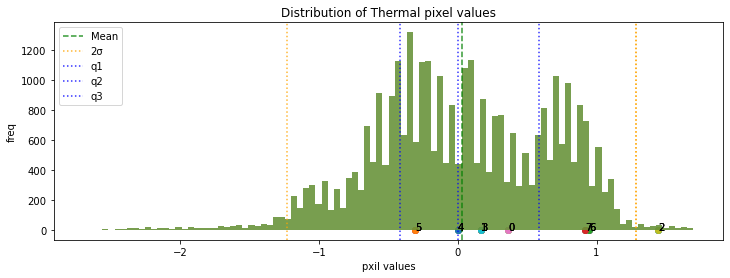

4983.jpg Single-Hotspot


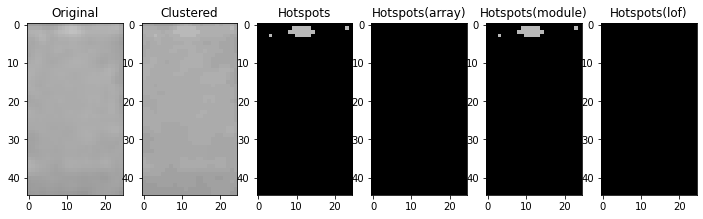

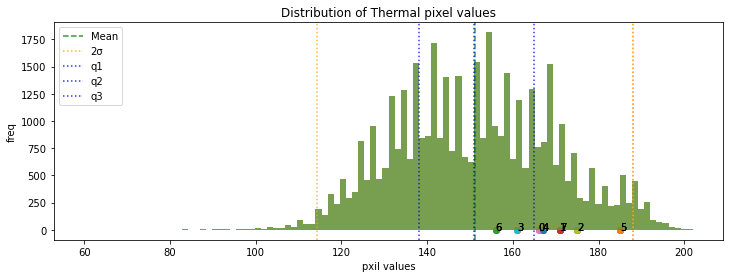

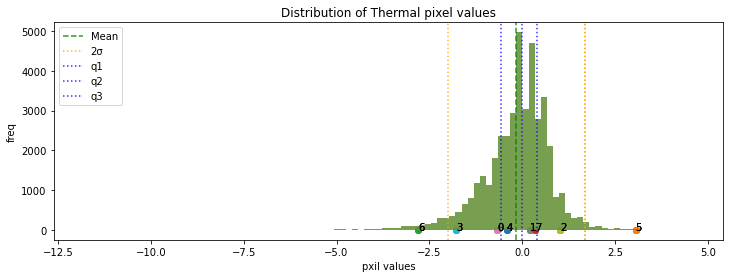

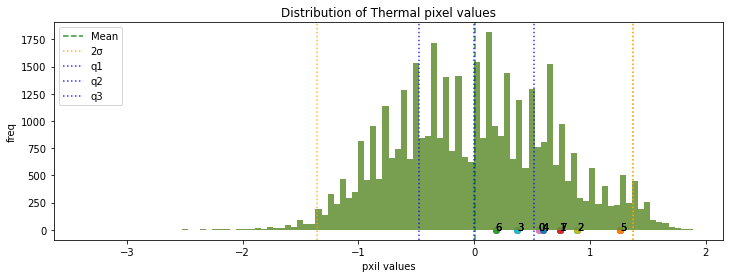

1596.jpg Single-Hotspot


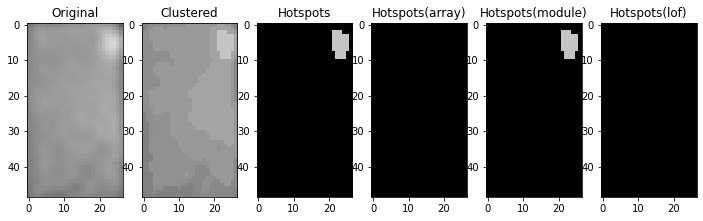

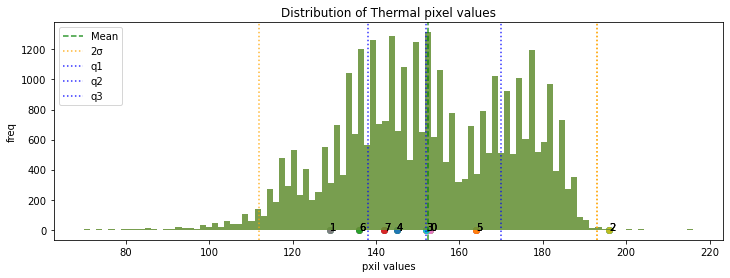

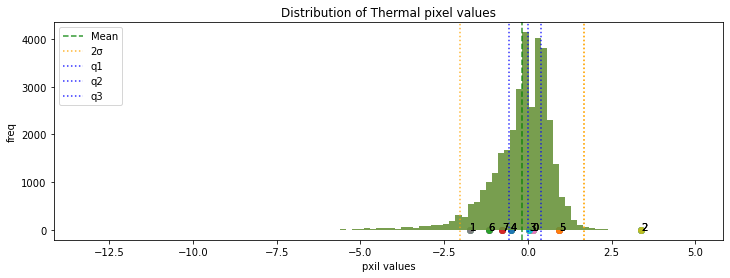

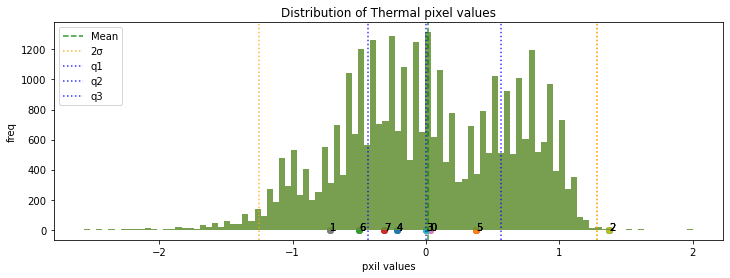

4148.jpg Single-Hotspot


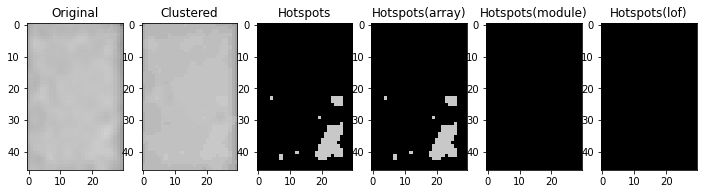

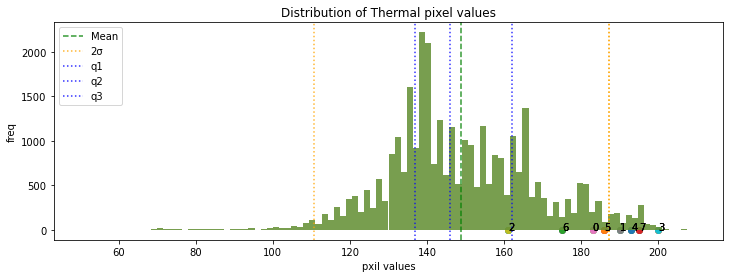

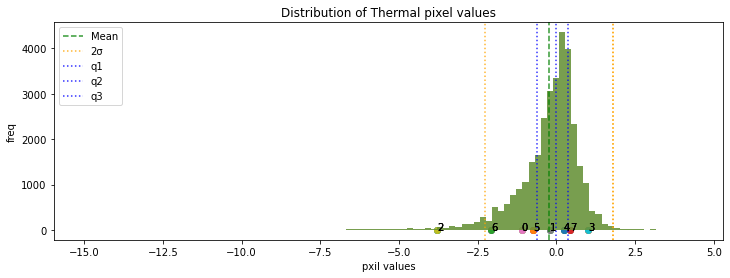

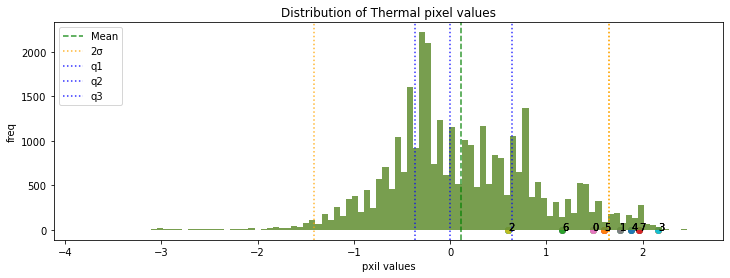

4174.jpg Single-Hotspot


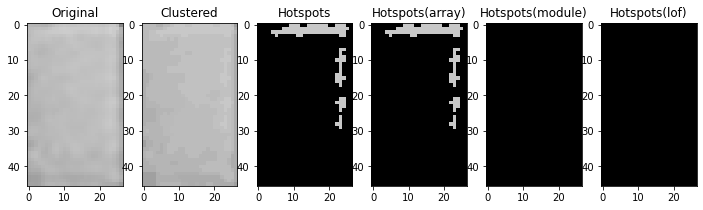

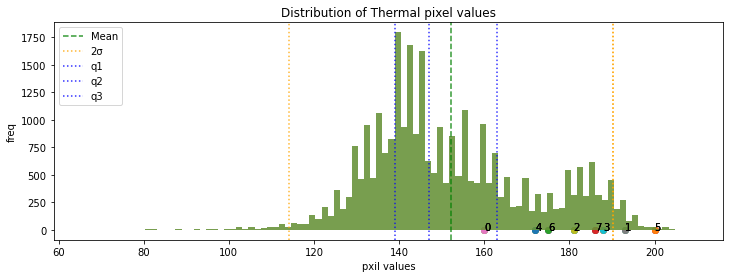

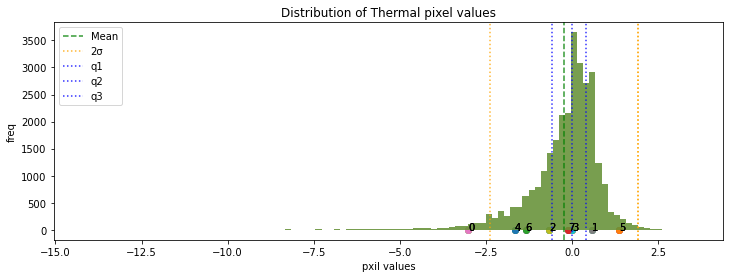

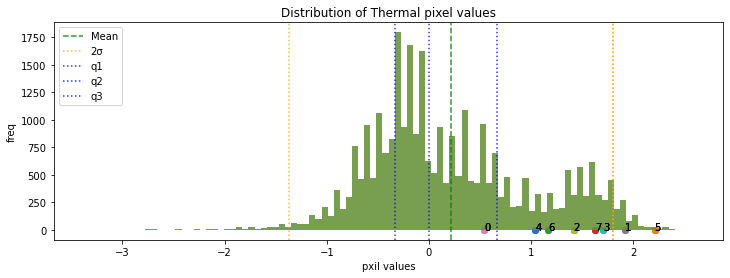

4612.jpg Single-Hotspot


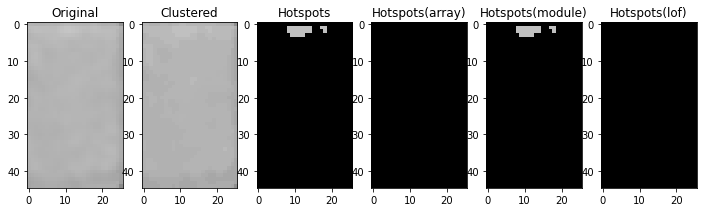

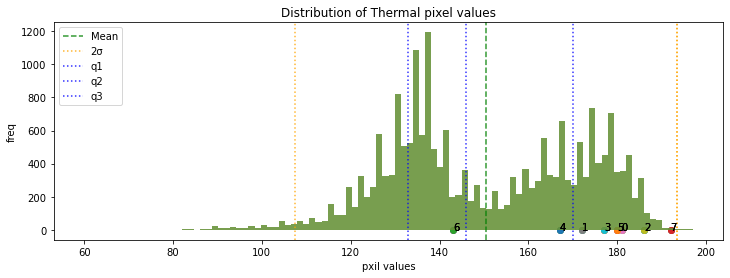

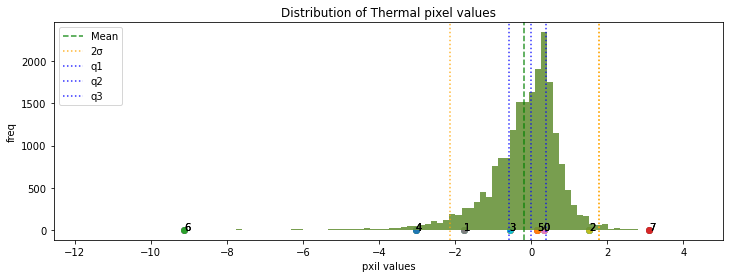

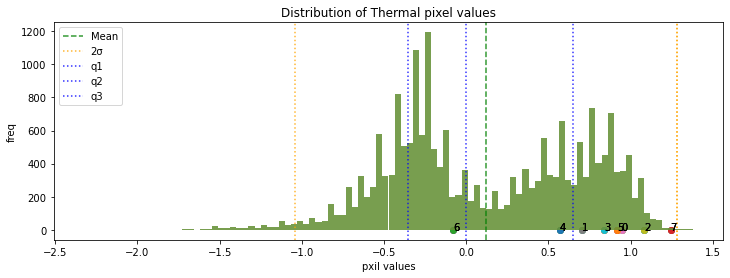

4941.jpg Multi-Hotspots


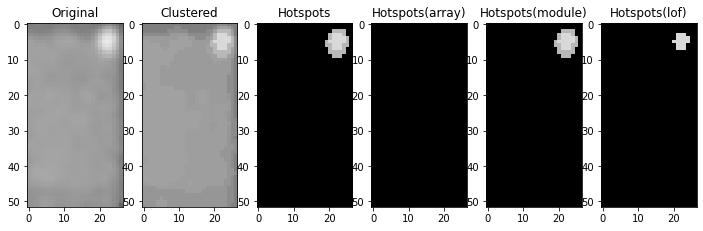

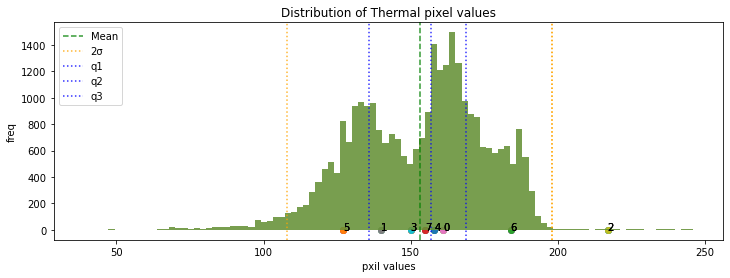

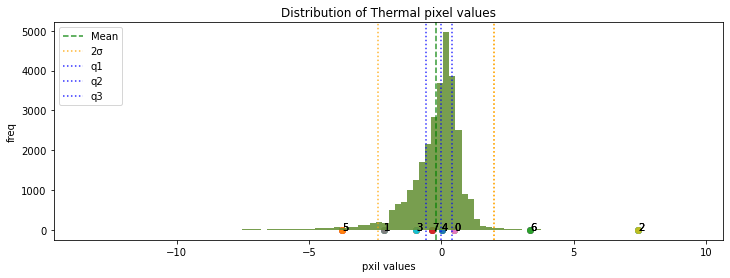

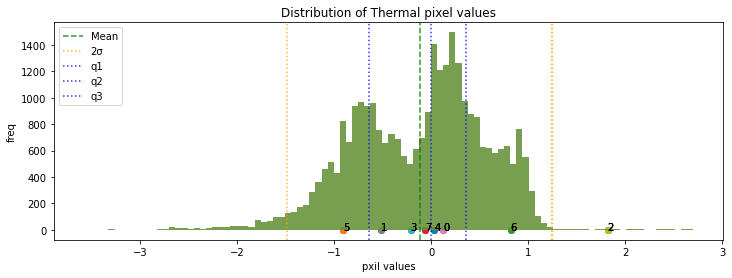

2459.jpg Single-Hotspot


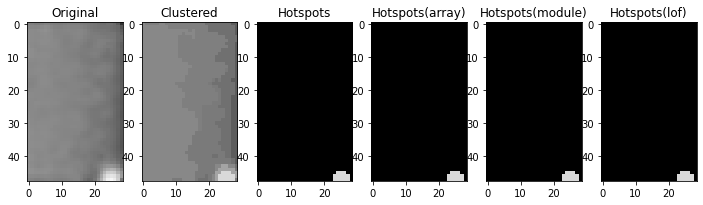

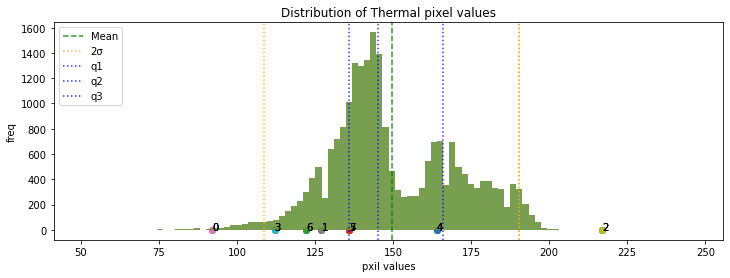

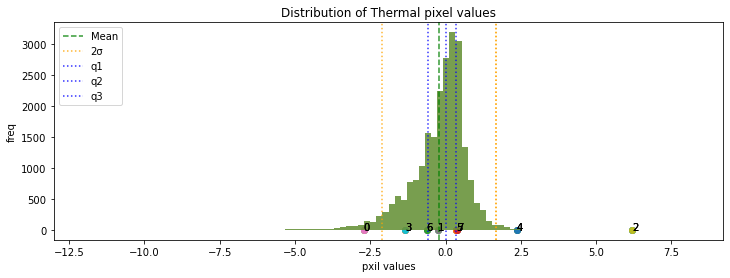

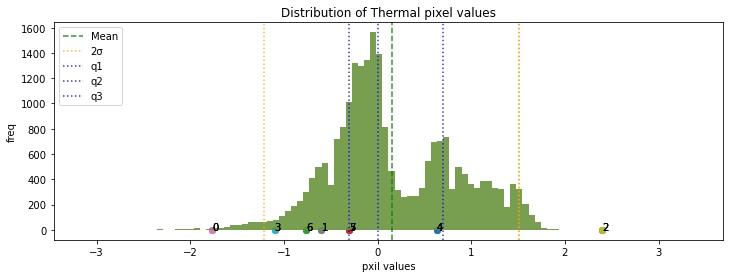

3592.jpg Single-Hotspot


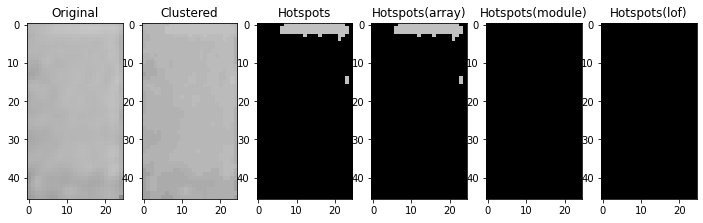

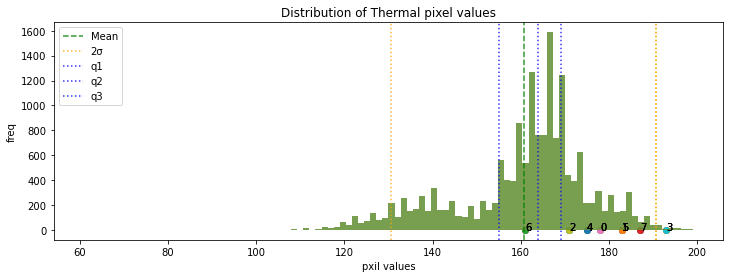

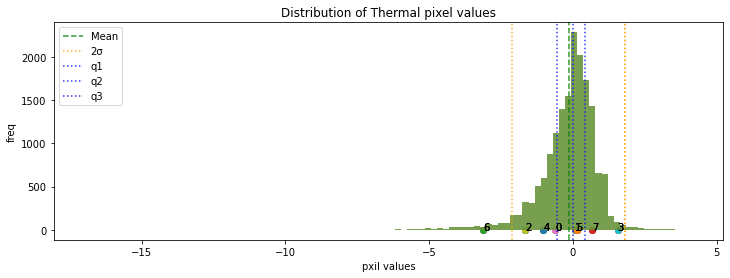

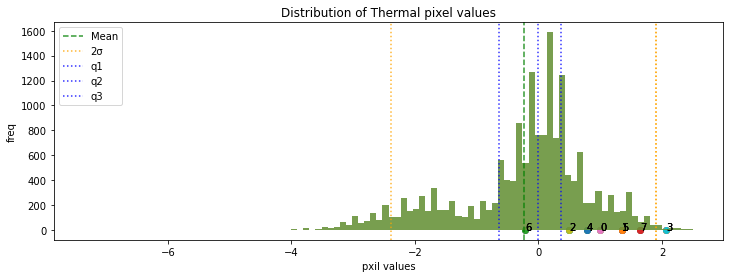

1408.jpg Multi-Hotspots


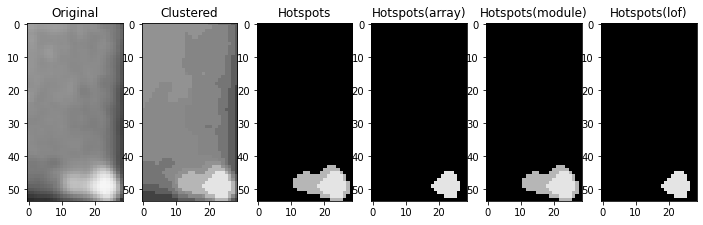

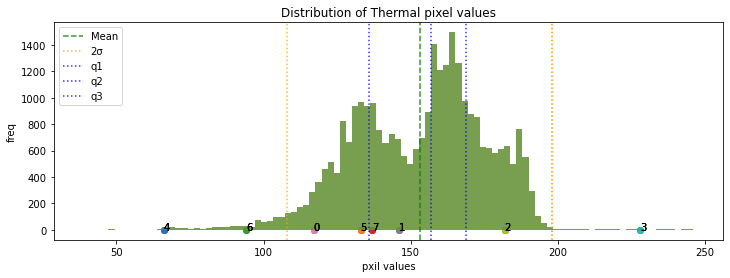

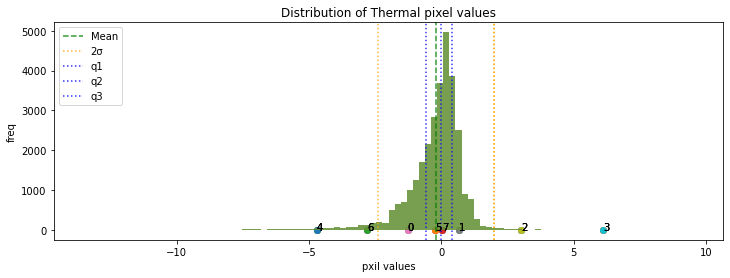

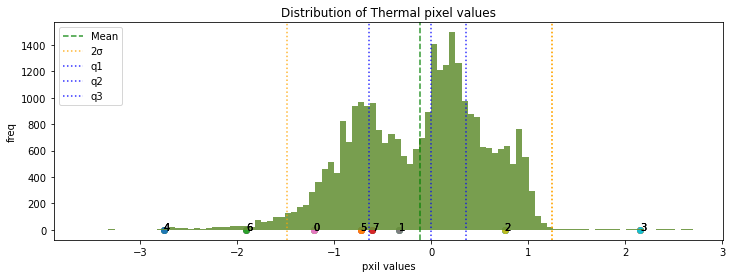

2301.jpg Single-Hotspot


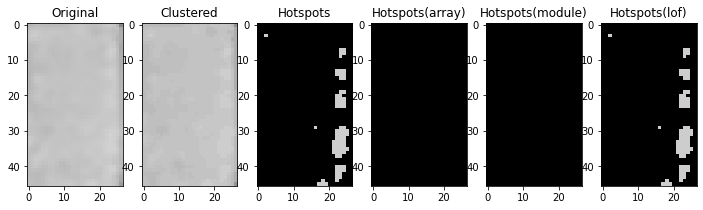

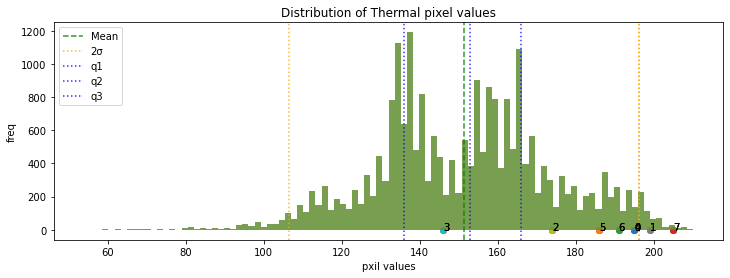

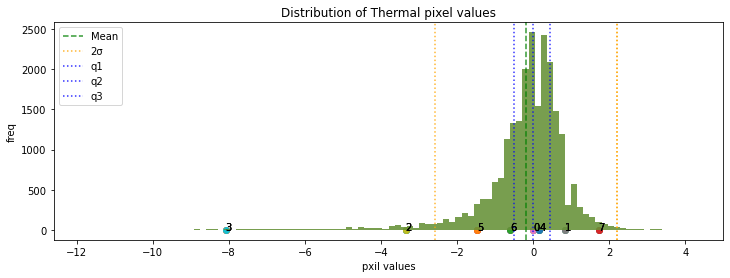

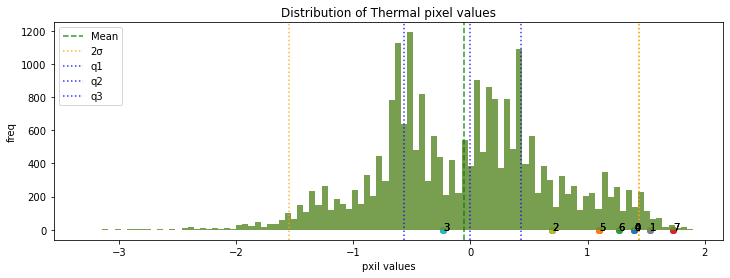

3426.jpg Single-Hotspot


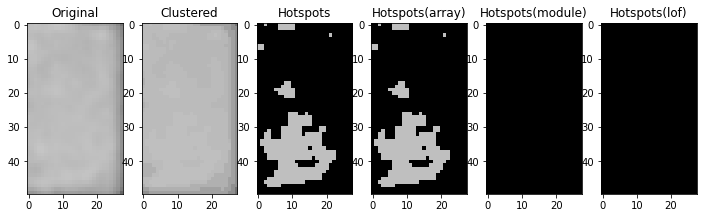

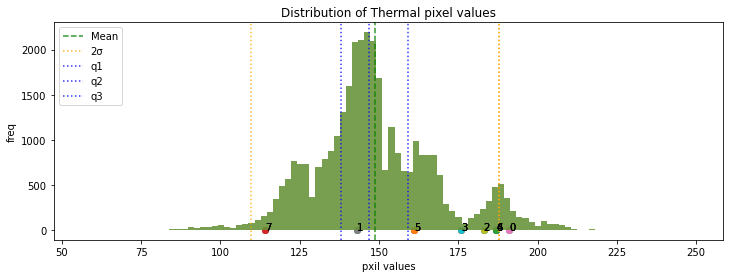

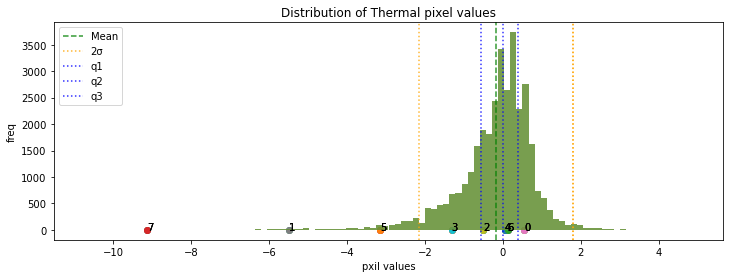

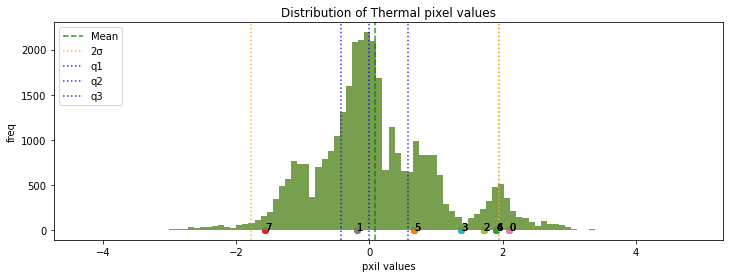

4822.jpg Single-Hotspot


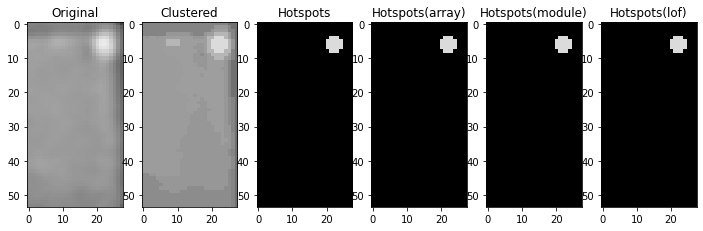

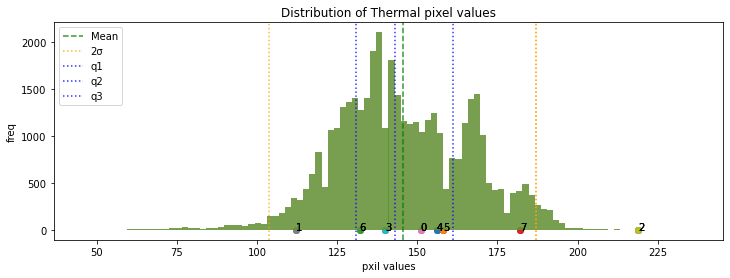

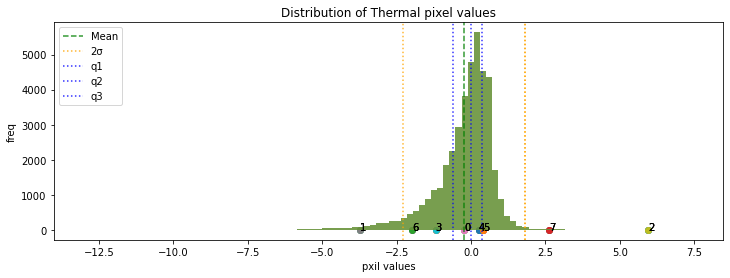

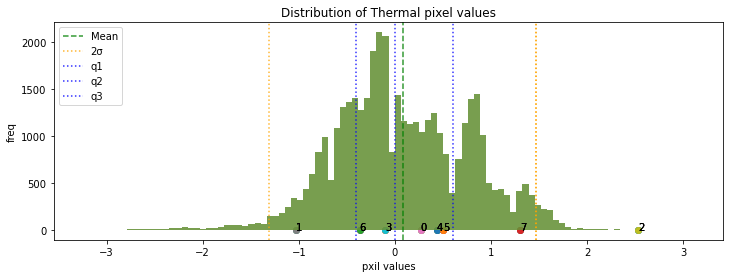

1755.jpg Multi-Hotspots


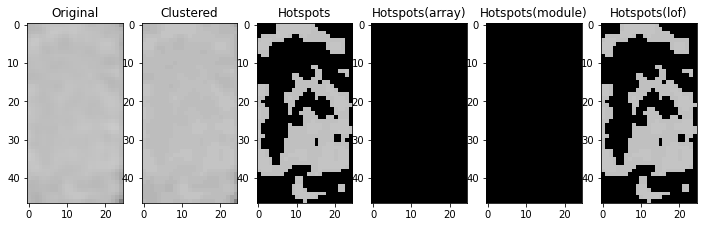

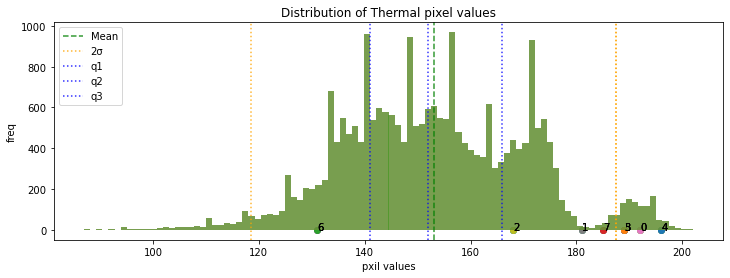

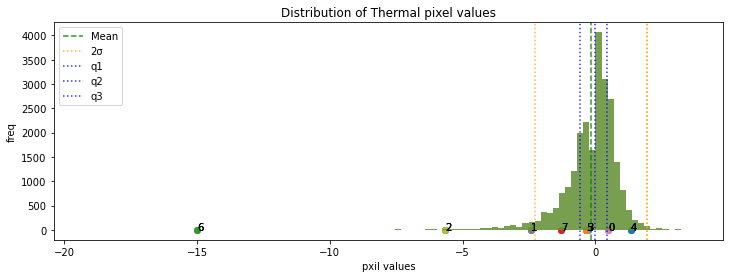

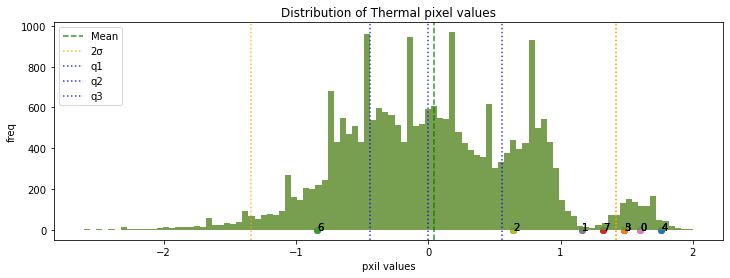

3977.jpg Single-Hotspot


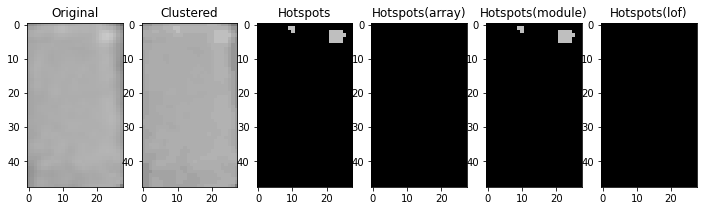

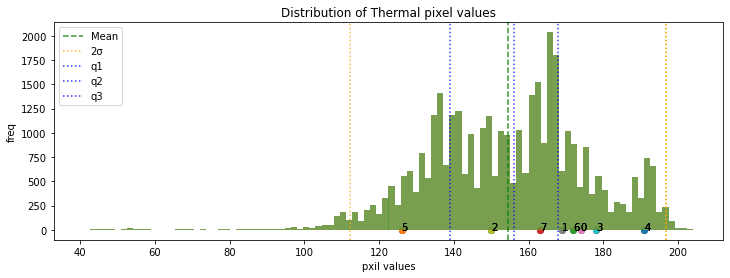

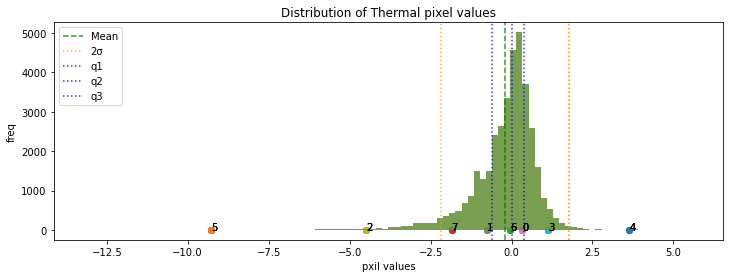

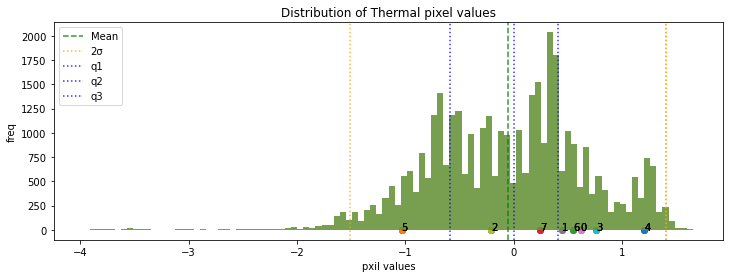

1621.jpg Single-Hotspot


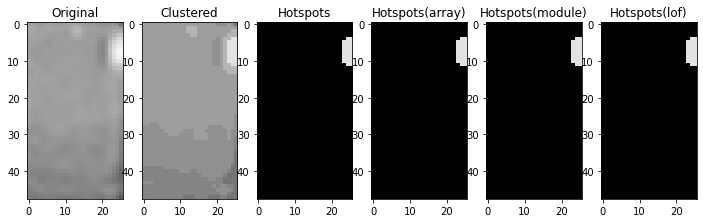

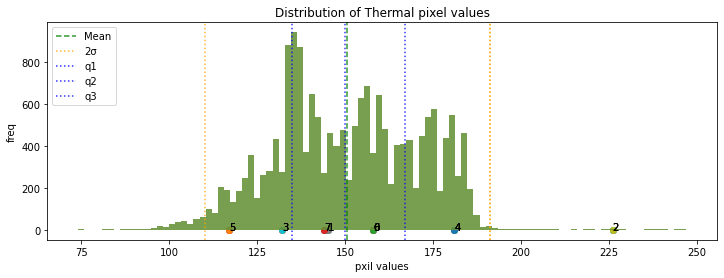

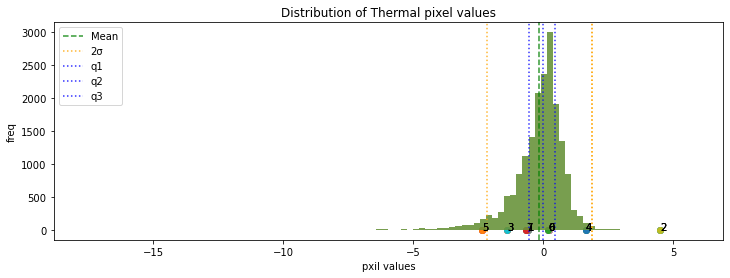

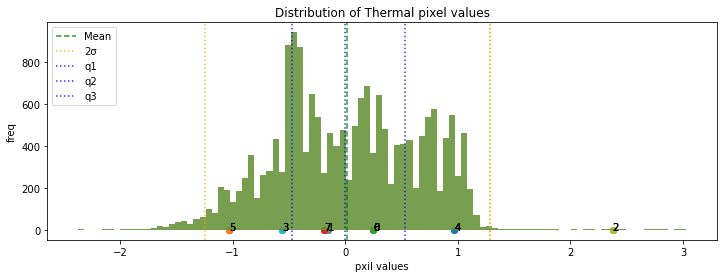

4003.jpg Single-Hotspot


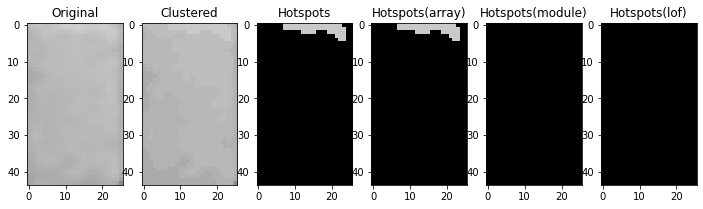

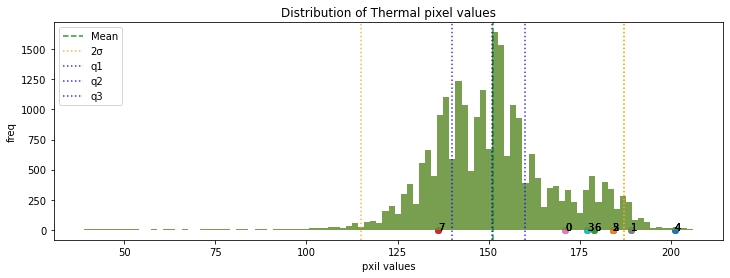

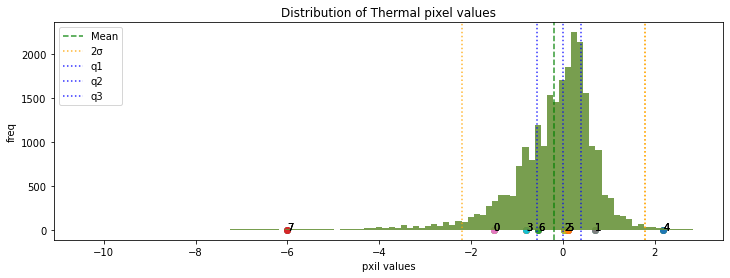

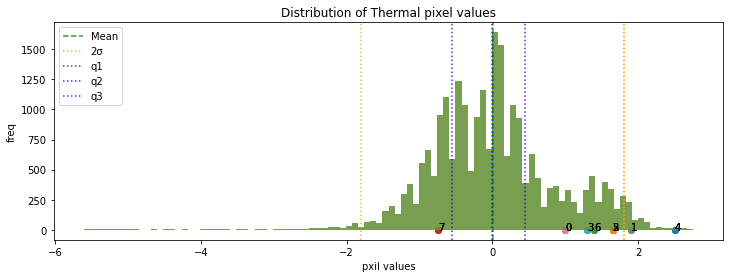

3585.jpg Single-Hotspot


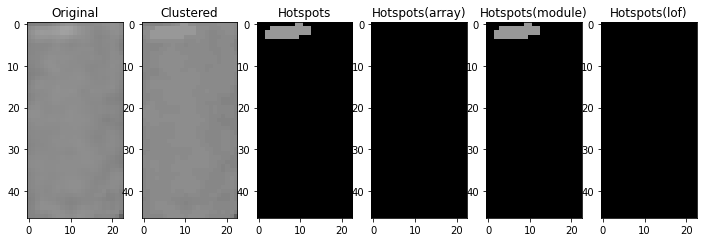

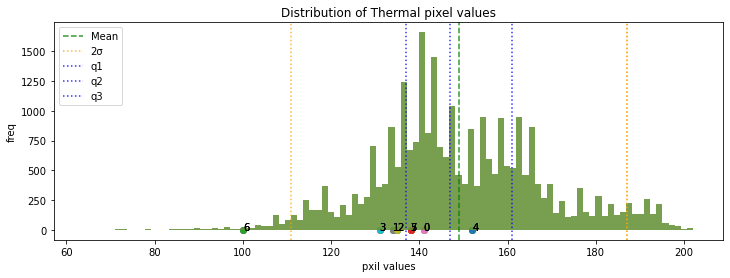

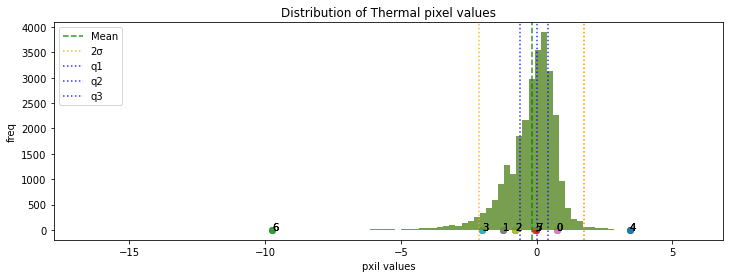

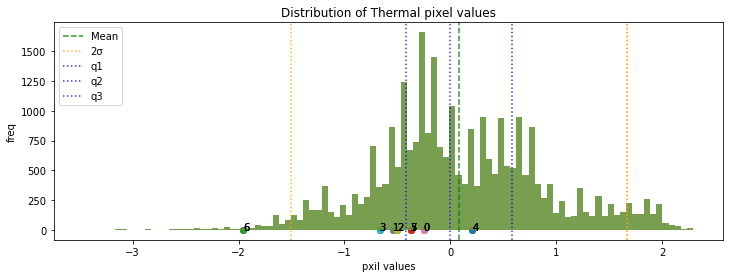

3591.jpg Single-Hotspot


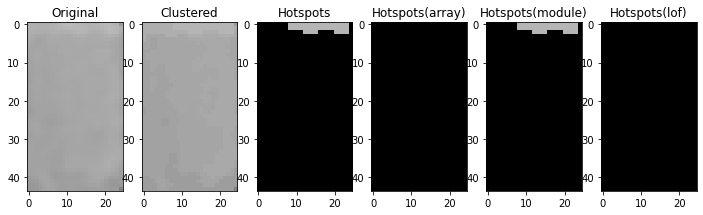

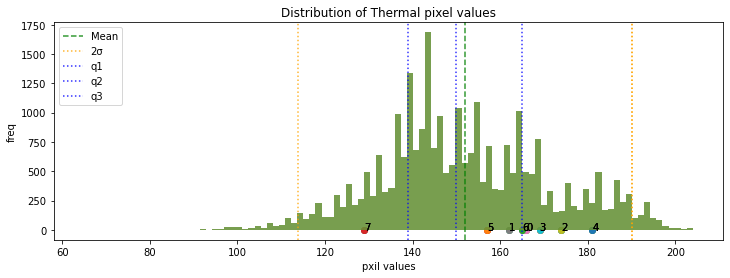

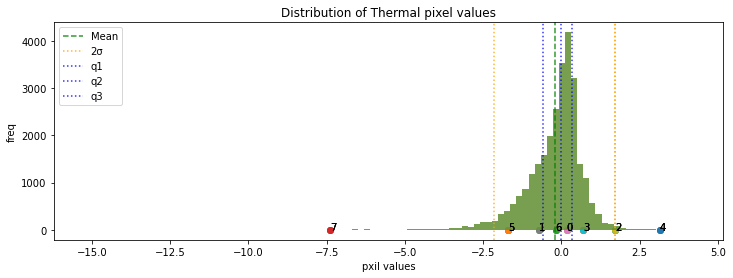

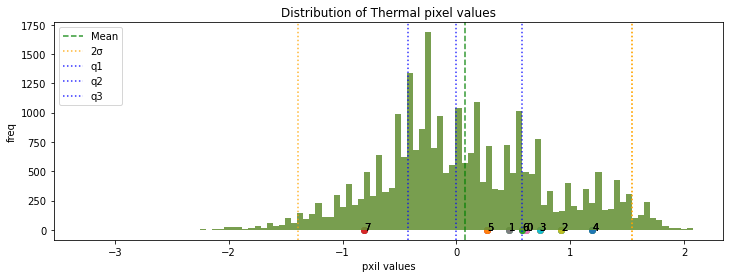

3546.jpg Multi-Hotspots


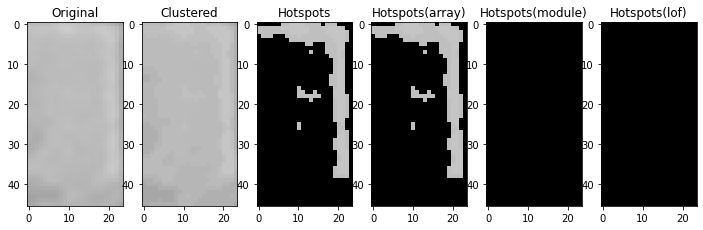

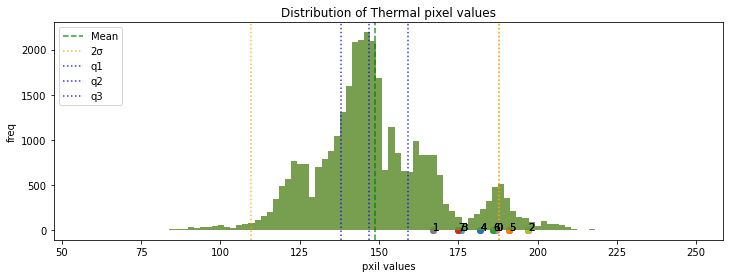

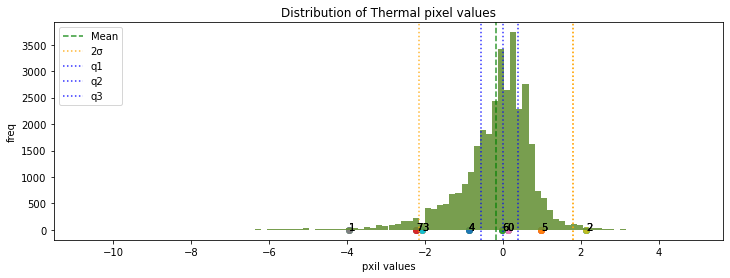

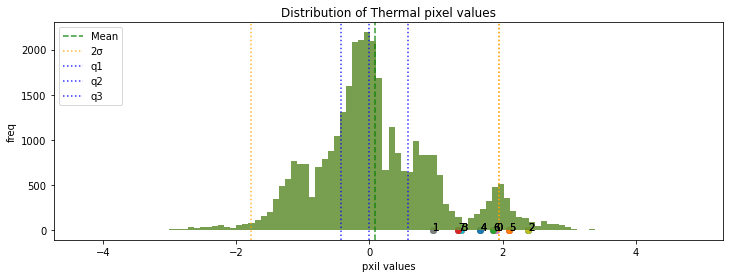

4567.jpg Multi-Hotspots


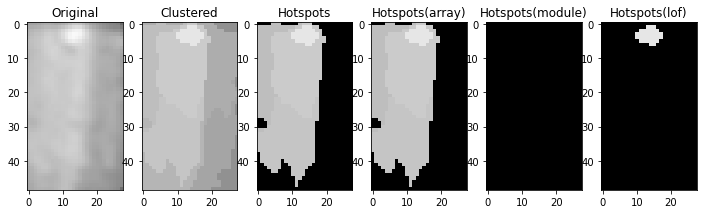

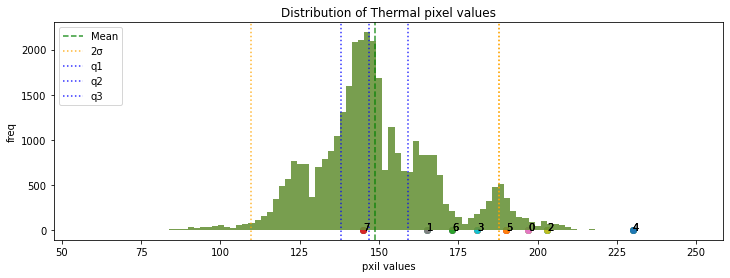

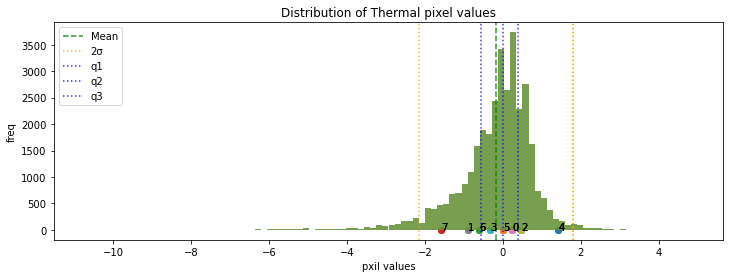

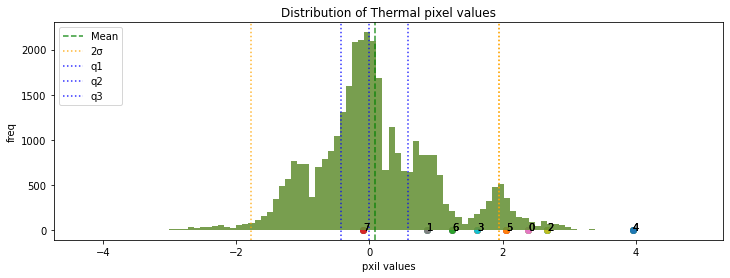

2890.jpg Single-Hotspot


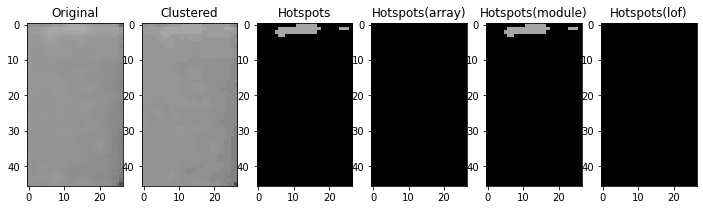

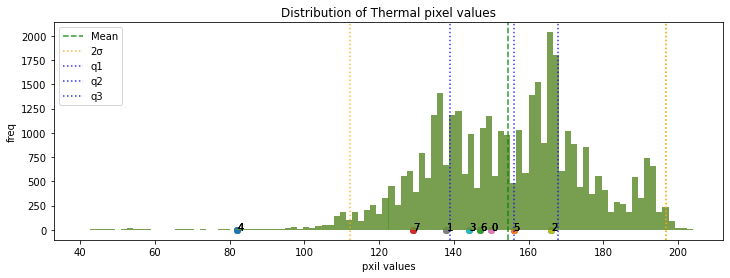

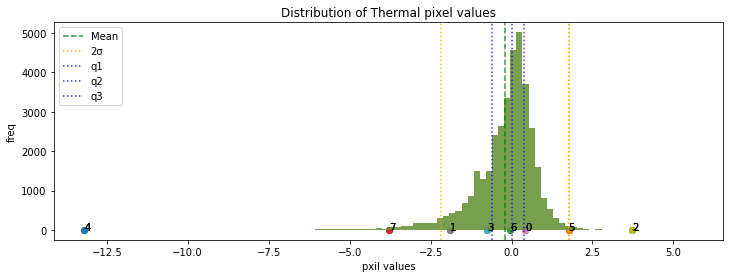

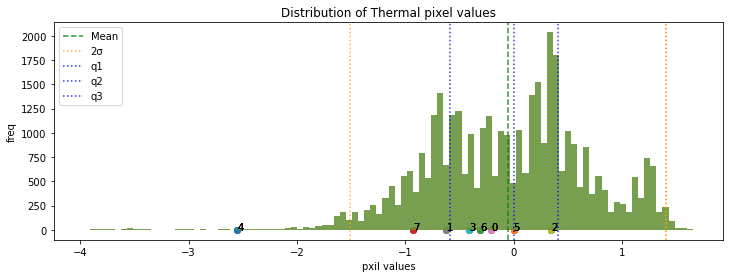

1631.jpg Cluster-Anomaly


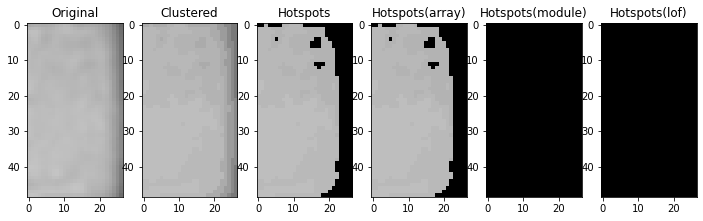

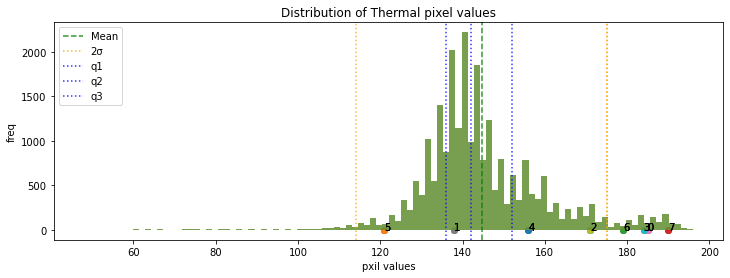

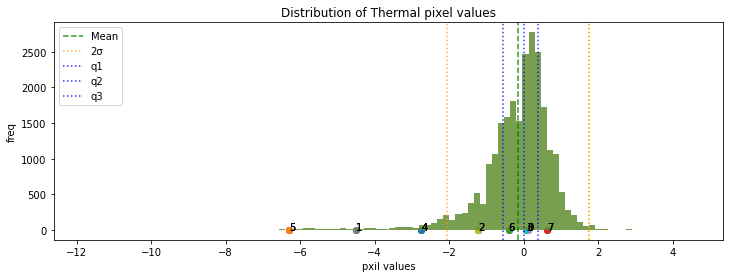

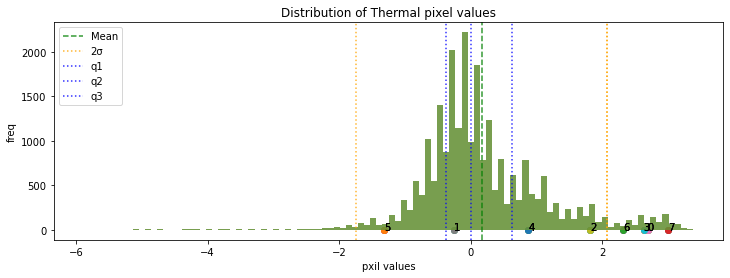

3768.jpg Single-Hotspot


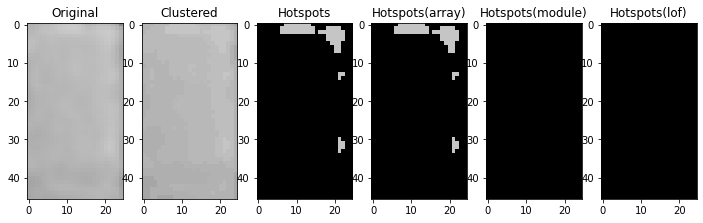

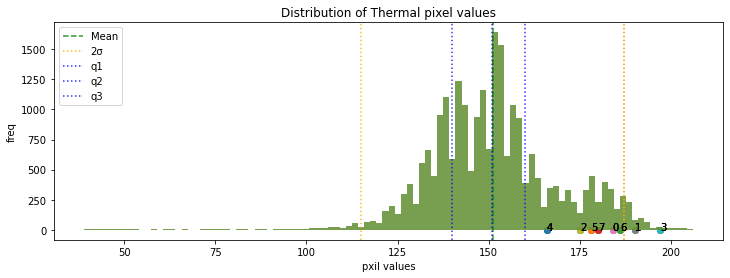

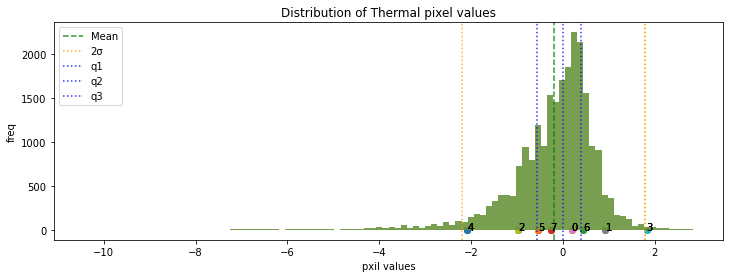

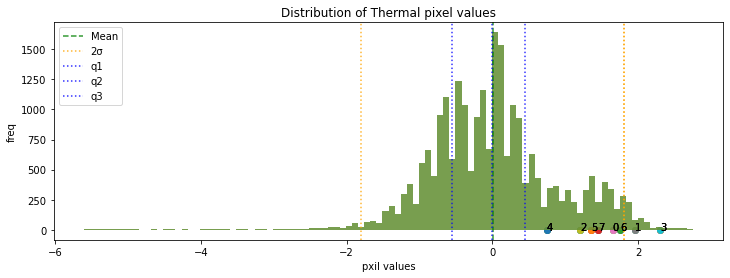

1816.jpg Single-Hotspot


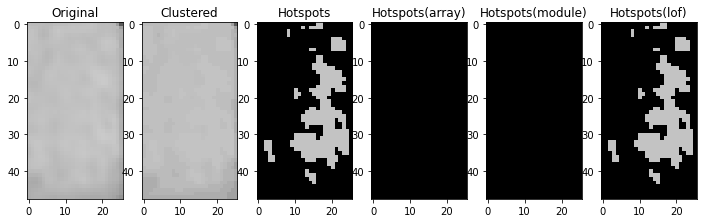

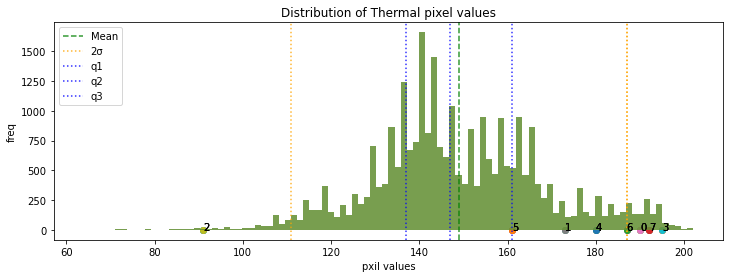

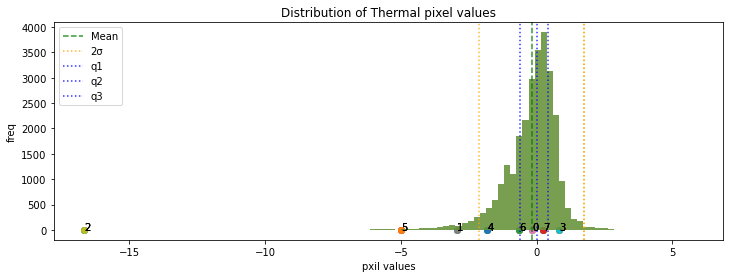

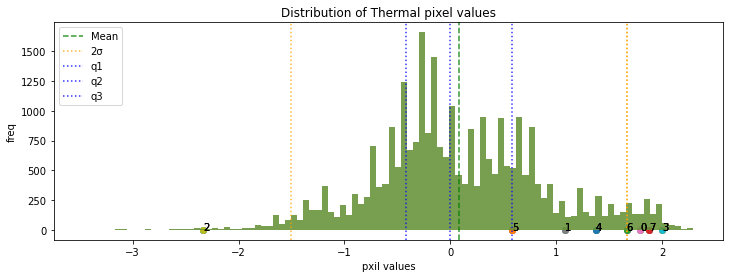

1751.jpg Single-Hotspot


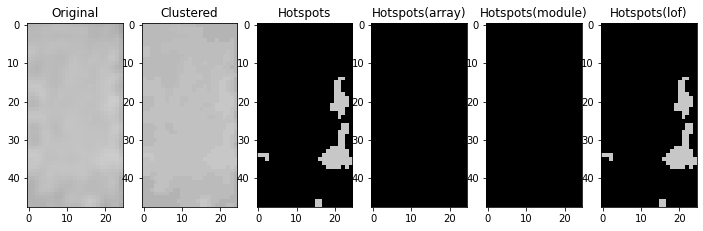

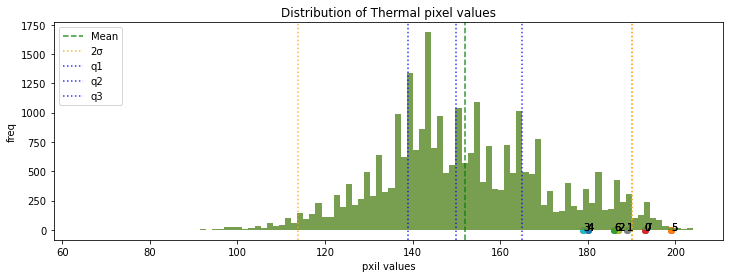

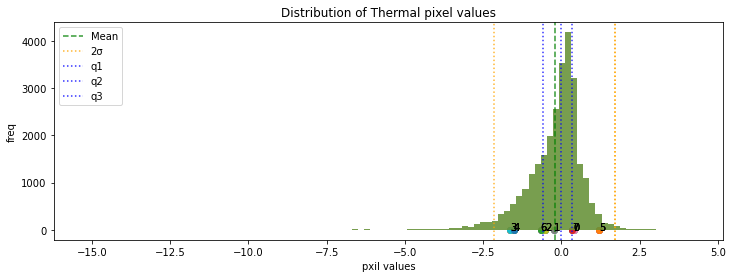

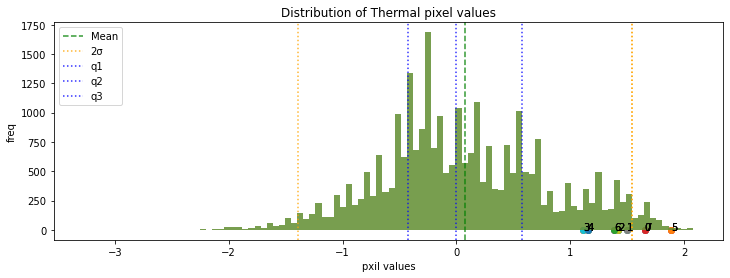

5053.jpg Single-Hotspot


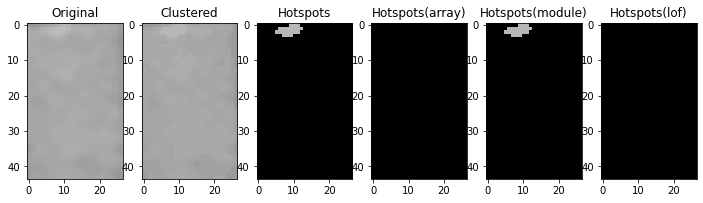

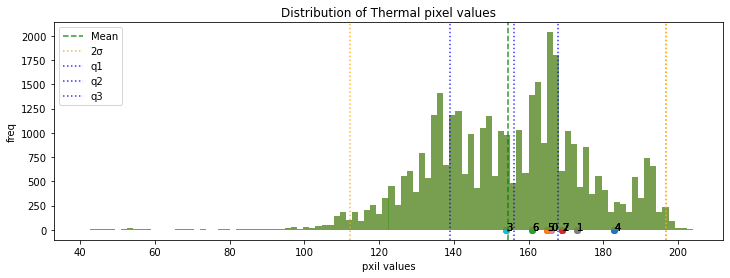

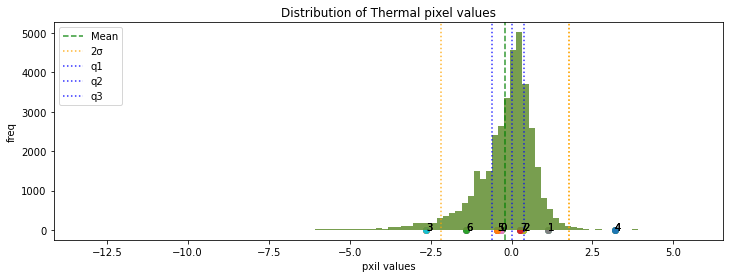

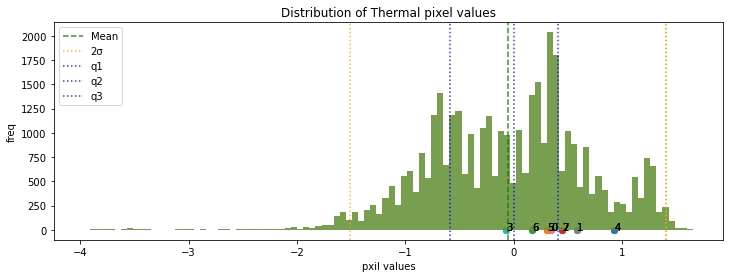

3436.jpg Single-Hotspot


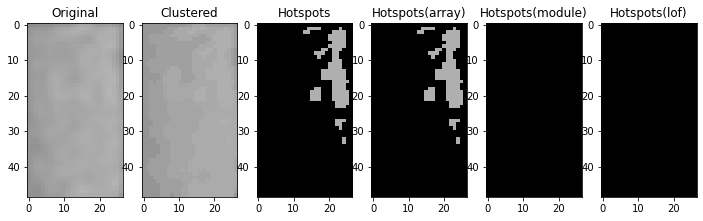

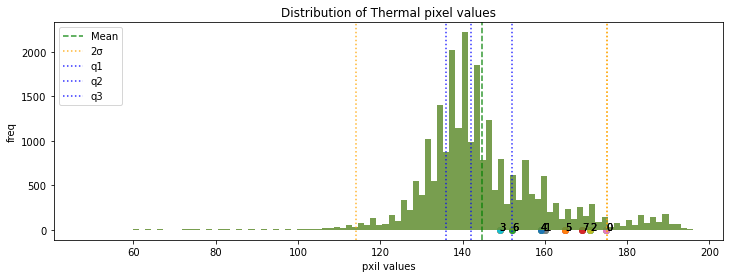

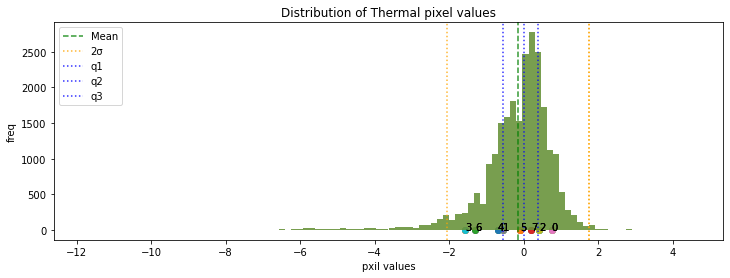

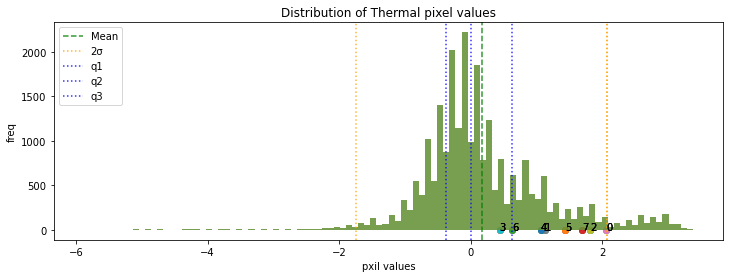

In [ ]:
anomaly_modules= {}
os.makedirs(input_dir_path+"/hist/",exist_ok=True)
#for n, k in enumerate(list(thermal_img_files)[:100]):
#for n, k in enumerate(list(thermal_img_files)[:200]):    
for n, k in enumerate(list(thermal_img_files)):    
    # -- module label --
    l = module_labels[n]
    if l == -1:
        pass
    else:
        # -- cluster temperature ---
        clusters = clustering.TemperatureClusters(
            data_array[l].scaled_temperature_with_index[k], method=clustering_method)  
        # -- original cluster --
        sliced_data = clusters.get_clusters_data(data_array[l].temperature[k])    
        original_clusters_temperature = np.stack([np.uint8(t.mean(axis=0)) for t in sliced_data])
        # -- scaled cluster --
        sliced_data = clusters.get_clusters_data(data_array[l].scaled_temperature[k])
        scaled_clusters_temperature = np.stack([t.mean(axis=0) for t in sliced_data ])
        # -- transformed temperature
        transformed_clusters_temperature = array_scaler[l].transform(original_clusters_temperature)
        # -- anomaly detection --    
        hot_pixels_in_array, hot_clusters_in_array = get_hotspots_in_array(
            transformed_clusters_temperature, thermal_img_files[k], log=False) 
        hot_pixels_in_module, hot_clusters_in_module = get_hotspots_in_module(
            scaled_clusters_temperature, transformed_clusters_temperature, 
            thermal_img_files[k], log=False)
        hot_pixcels_lof, hot_clusters_lof = get_hotspots_lof(
            original_clusters_temperature, transformed_clusters_temperature, 
            thermal_img_files[k], log=False)
        hot_pixels = (hot_pixels_in_array | hot_pixels_in_module | hot_pixcels_lof)
        hot_clusters = (hot_clusters_in_array | hot_clusters_in_module | hot_clusters_lof)
        #hot_pixels = (hot_pixels_in_module | hot_pixcels_lof)
        #hot_clusters = (hot_clusters_in_module | hot_clusters_lof)
        #hot_pixels = hot_pixcels_lof
        #hot_clusters = hot_clusters_lof
        module_type = anomaly_detection.detect_module_type(hot_clusters, hot_pixels)
        # -- save anomaly modules --
        if module_type not in anomaly_modules:
            anomaly_modules[module_type] = [k]
        else:
            anomaly_modules[module_type].append(k)
        # -- display -- 
        img_clustered = original_clusters_temperature[clusters.labels].reshape(thermal_img_files[k].shape)
        img_hotspots = img_clustered * hot_pixels
        img_hotspots_in_array = img_clustered * hot_pixels_in_array
        img_hotspots_in_module = img_clustered * hot_pixels_in_module
        img_hotspots_lof = img_clustered * hot_pixcels_lof
        if module_type != "Normal":
            print(k, module_type)
            display.display_modules({
                "Original": thermal_img_files[k], 
                "Clustered": img_clustered,
                "Hotspots": img_hotspots,
                "Hotspots(array)": img_hotspots_in_array,
                "Hotspots(module)": img_hotspots_in_module,
                "Hotspots(lof)": img_hotspots_lof
            })
            display.display_distributions(
                data_array[l].all_temperature,            
                filepath = input_dir_path+"/hist/hist_original_" + k,
                cluster_centers = original_clusters_temperature
            )
            display.display_distributions(
                data_array[l].scaled_all_temperature, 
                filepath = input_dir_path+"/hist/hist_scaled_" + k,
                cluster_centers = scaled_clusters_temperature
            )    
            display.display_distributions(
                array_scaler[l].transform(data_array[l].all_temperature),
                filepath = input_dir_path+"/hist/hist_transformed_" + k,
                cluster_centers = transformed_clusters_temperature
            )    

In [ ]:
for n, k in enumerate(list(thermal_img_files)):    
    # -- module label --
    l = module_labels[n]
    if l == -1:
        pass
    elif k in ["190.jpg", "1991.jpg", "2195.jpg", "2078.jpg", "3672.jpg", "1561.jpg"]:
        print(k)
        # -- cluster temperature ---
        clusters = clustering.TemperatureClusters(
            data_array[l].scaled_temperature_with_index[k], method=clustering_method)  
        # -- original cluster --
        sliced_data = clusters.get_clusters_data(data_array[l].temperature[k])    
        original_clusters_temperature = np.stack([np.uint8(t.mean(axis=0)) for t in sliced_data])
        # -- scaled cluster --
        sliced_data = clusters.get_clusters_data(data_array[l].scaled_temperature[k])
        scaled_clusters_temperature = np.stack([t.mean(axis=0) for t in sliced_data ])
        # -- transformed temperature
        transformed_clusters_temperature = array_scaler[l].transform(original_clusters_temperature)
        # -- anomaly detection --    
        hot_pixels_in_array, hot_clusters_in_array = get_hotspots_in_array(
            transformed_clusters_temperature, thermal_img_files[k], log=False) 
        hot_pixels_in_module, hot_clusters_in_module = get_hotspots_in_module(
            scaled_clusters_temperature, transformed_clusters_temperature, 
            thermal_img_files[k], log=False)
        hot_pixcels_lof, hot_clusters_lof = get_hotspots_lof(
            original_clusters_temperature, transformed_clusters_temperature, 
            thermal_img_files[k], log=False)
        #hot_pixels = (hot_pixels_in_array | hot_pixels_in_module | hot_pixcels_lof)
        #hot_clusters = (hot_clusters_in_array | hot_clusters_in_module | hot_clusters_lof)
        hot_pixels = (hot_pixels_in_module | hot_pixcels_lof)
        hot_clusters = (hot_clusters_in_module | hot_clusters_lof)
        #hot_pixels = hot_pixcels_lof
        #hot_clusters = hot_clusters_lof
        module_type = anomaly_detection.detect_module_type(hot_clusters, hot_pixels)
        # -- save anomaly modules --
        if module_type not in anomaly_modules:
            anomaly_modules[module_type] = [k]
        else:
            anomaly_modules[module_type].append(k)
        # -- display -- 
        img_clustered = original_clusters_temperature[clusters.labels].reshape(thermal_img_files[k].shape)
        img_hotspots = img_clustered * hot_pixels
        img_hotspots_in_array = img_clustered * hot_pixels_in_array
        img_hotspots_in_module = img_clustered * hot_pixels_in_module
        img_hotspots_lof = img_clustered * hot_pixcels_lof
        print(k, module_type)
        display.display_modules({
            "Original": thermal_img_files[k], 
            "Clustered": img_clustered,
            "Hotspots": img_hotspots,
            "Hotspots(array)": img_hotspots_in_array,
            "Hotspots(module)": img_hotspots_in_module,
            "Hotspots(lof)": img_hotspots_lof
        })
        display.display_distributions(
            data_array[l].all_temperature,            
            filepath = input_dir_path+"/hist/hist_original_" + k,
            cluster_centers = original_clusters_temperature
        )
        display.display_distributions(
            data_array[l].scaled_all_temperature, 
            filepath = input_dir_path+"/hist/hist_scaled_" + k,
            cluster_centers = scaled_clusters_temperature
            )    
        display.display_distributions(
            array_scaler[l].transform(data_array[l].all_temperature),
            filepath = input_dir_path+"/hist/hist_transformed_" + k,
            cluster_centers = transformed_clusters_temperature
        )    

異常モジュールデータの保存

In [ ]:
import json
with open(input_dir_path+"/anomaly_modules.json", "w") as f:
    json.dump(anomaly_modules, f, indent=4, sort_keys=True, separators=(',', ': '))

In [ ]:
with open(input_dir_path+"/anomaly_modules.json", "r") as f:
    anomaly_modules = json.load(f)

モジュール可視化

In [ ]:
modules = Modules(module_contours)

In [ ]:
img_con_index = modules.get_img_contours(img_org, index=True)
module_extraction.show_img({"extracted modules":img_con_index},cmap="gray",figsize=(30,30))

In [ ]:
img_con = modules.get_img_contours(img_org, index=False)
img_mask = cv2.bitwise_and(img_org, img_con)
img_mask_index = modules.add_index(img_mask)
module_extraction.show_img({"extracted modules (overlay)":img_mask_index},cmap="gray",figsize=(30,30))

異常モジュール可視化

In [ ]:
anomaly_contours = modules.get_anomaly_contours(anomaly_modules)

In [ ]:
import copy
color_list = {
    "Single-Hotspot": (0,255,255), # aqua
    "Multi-Hotspots": (0,255,0), # green
    "Cluster-Anomaly": (255,255,0), # yellow
    "Module-Anomaly": (255,165,0), # orange
    "String-Anomaly": (238,130,238) # violet
}
img_target_index = copy.deepcopy(img_mask_index)
for k, v in anomaly_contours.items():
    if k == "Normal":
        continue
    else:
        img_target_index = modules.get_img_target_contours(
            img_target_index, v, index=True, color=color_list[k])
module_extraction.show_img(
    {"highlighted modules":img_target_index}, cmap="gray", figsize=(30,30)
)

In [ ]:
img_write = cv2.cvtColor(img_target_index, cv2.COLOR_BGR2RGB)
cv2.imwrite(input_dir_path+'/img_target_index.png',img_write)

ストリング異常を含めた異常モジュール可視化

In [ ]:
if "Module-Anomaly" in anomaly_contours:
    string_anomaly_labels = modules.get_dbscan_labels(anomaly_contours["Module-Anomaly"])
    string_anomaly_modules = np.array(anomaly_modules["Module-Anomaly"])[string_anomaly_labels > 0]
    anomaly_modules["String-Anomaly"] = list(string_anomaly_modules )

In [ ]:
anomaly_contours = modules.get_anomaly_contours(anomaly_modules)

In [ ]:
img_target_index = copy.deepcopy(img_mask_index)
for k, v in anomaly_contours.items():
    if k == "Normal":
        continue
    else:
        img_target_index = modules.get_img_target_contours(
            img_target_index, v, index=True, color=color_list[k])
module_extraction.show_img(
    {"highlighted modules":img_target_index}, cmap="gray", figsize=(30,30)
)

In [ ]:
img_write = cv2.cvtColor(img_target_index, cv2.COLOR_BGR2RGB)
cv2.imwrite(input_dir_path+'/img_target_w_string_index.png',img_write)

In [ ]:
with open(input_dir_path+"/anomaly_modules.json", "w") as f:
    json.dump(anomaly_modules, f, indent=4, sort_keys=True, separators=(',', ': '))